In [1]:
import pickle
import copy
from experiments import *
from utils import *

Definitions

In [2]:
scenarios = {'cnn':['summarization_cnndm:temperature=0.3,device=cuda,'], 
             'xsum':['summarization_xsum:temperature=0.3,device=cuda,'], 
             'boolq:':['boolq:'],
             'civil_comments':['civil_comments:demographic=LGBTQ,',
                               'civil_comments:demographic=all,',
                               'civil_comments:demographic=black,',
                               'civil_comments:demographic=christian,',
                               'civil_comments:demographic=female,',
                               'civil_comments:demographic=male,',
                               'civil_comments:demographic=muslim,',
                               'civil_comments:demographic=other_religions,',
                               'civil_comments:demographic=white,'],
             'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':['commonsense:dataset=hellaswag,method=multiple_choice_separate_original,'],
             'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':['commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,'],
             'imdb:':['imdb:'],
             'mmlu':['mmlu:subject=abstract_algebra,method=multiple_choice_joint,',
                     'mmlu:subject=college_chemistry,method=multiple_choice_joint,',
                     'mmlu:subject=computer_security,method=multiple_choice_joint,',
                     'mmlu:subject=econometrics,method=multiple_choice_joint,',
                     'mmlu:subject=us_foreign_policy,method=multiple_choice_joint,'],
             'msmarco:track=regular,valid_topk=30,':['msmarco:track=regular,valid_topk=30,'],
             #'msmarco:track=trec,valid_topk=30,':['msmarco:track=trec,valid_topk=30,'],
             'narrative_qa:':['narrative_qa:'],
             'natural_qa:mode=closedbook,':['natural_qa:mode=closedbook,'],
             'natural_qa:mode=openbook_longans,':['natural_qa:mode=openbook_longans,'],
             'quac:':['quac:'],
             'raft':['raft:subset=ade_corpus_v2,',
                     'raft:subset=banking_77,',
                     'raft:subset=neurips_impact_statement_risks,',
                     'raft:subset=one_stop_english,',
                     'raft:subset=overruling,',
                     'raft:subset=semiconductor_org_types,',
                     'raft:subset=systematic_review_inclusion,',
                     'raft:subset=tai_safety_research,',
                     'raft:subset=terms_of_service,',
                     'raft:subset=tweet_eval_hate,',
                     'raft:subset=twitter_complaints,'],
             'truthful_qa:task=mc_single,method=multiple_choice_joint,':['truthful_qa:task=mc_single,method=multiple_choice_joint,']}
            
scenarios_metrics = {'boolq:':'em', 
                     'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':'em',
                     'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':'em',
                     'imdb:':'em', 
                     'mmlu':'em', 
                     'msmarco:track=regular,valid_topk=30,':'RR@10', 
                     'msmarco:track=trec,valid_topk=30,':'NDCG@10', 
                     'narrative_qa:':'f1', 
                     'natural_qa:mode=closedbook,':'f1', 
                     'natural_qa:mode=openbook_longans,':'f1', 
                     'quac:':'f1', 
                     'raft':'em', 
                     'truthful_qa:task=mc_single,method=multiple_choice_joint,':'em'}

## Data

Loading data

In [3]:
with open('data/helm.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [4]:
data['data'].keys()

dict_keys(['boolq:', 'civil_comments:demographic=LGBTQ,', 'civil_comments:demographic=all,', 'civil_comments:demographic=black,', 'civil_comments:demographic=christian,', 'civil_comments:demographic=female,', 'civil_comments:demographic=male,', 'civil_comments:demographic=muslim,', 'civil_comments:demographic=other_religions,', 'civil_comments:demographic=white,', 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,', 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,', 'imdb:', 'mmlu:subject=abstract_algebra,method=multiple_choice_joint,', 'mmlu:subject=college_chemistry,method=multiple_choice_joint,', 'mmlu:subject=computer_security,method=multiple_choice_joint,', 'mmlu:subject=econometrics,method=multiple_choice_joint,', 'mmlu:subject=us_foreign_policy,method=multiple_choice_joint,', 'msmarco:track=regular,valid_topk=30,', 'msmarco:track=trec,valid_topk=30,', 'narrative_qa:', 'natural_qa:mode=closedbook,', 'natural_qa:mode=openbook_longan

In [5]:
(data['data']['summarization_cnndm:temperature=0.3,device=cuda,']['correctness']<1).mean()

1.0

In [6]:
(data['data']['summarization_cnndm:temperature=0.3,device=cuda,']['correctness']==0).mean()

0.1195

In [7]:
data['data'].keys()

dict_keys(['boolq:', 'civil_comments:demographic=LGBTQ,', 'civil_comments:demographic=all,', 'civil_comments:demographic=black,', 'civil_comments:demographic=christian,', 'civil_comments:demographic=female,', 'civil_comments:demographic=male,', 'civil_comments:demographic=muslim,', 'civil_comments:demographic=other_religions,', 'civil_comments:demographic=white,', 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,', 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,', 'imdb:', 'mmlu:subject=abstract_algebra,method=multiple_choice_joint,', 'mmlu:subject=college_chemistry,method=multiple_choice_joint,', 'mmlu:subject=computer_security,method=multiple_choice_joint,', 'mmlu:subject=econometrics,method=multiple_choice_joint,', 'mmlu:subject=us_foreign_policy,method=multiple_choice_joint,', 'msmarco:track=regular,valid_topk=30,', 'msmarco:track=trec,valid_topk=30,', 'narrative_qa:', 'natural_qa:mode=closedbook,', 'natural_qa:mode=openbook_longan

## Results

In [8]:
data['models']

['ai21_j1-grande',
 'ai21_j1-grande-v2-beta',
 'ai21_j1-jumbo',
 'ai21_j1-large',
 'anthropic_stanford-online-all-v4-s3',
 'cohere_command-medium-beta',
 'cohere_command-xlarge-beta',
 'cohere_large-20220720',
 'cohere_medium-20220720',
 'cohere_medium-20221108',
 'cohere_xlarge-20220609',
 'cohere_xlarge-20221108',
 'microsoft_TNLGv2_530B',
 'microsoft_TNLGv2_7B',
 'openai_ada',
 'openai_babbage',
 'openai_curie',
 'openai_davinci',
 'openai_text-ada-001',
 'openai_text-babbage-001',
 'openai_text-curie-001',
 'openai_text-davinci-002',
 'openai_text-davinci-003',
 'together_bloom',
 'together_gpt-j-6b',
 'together_gpt-neox-20b',
 'together_opt-175b',
 'together_opt-66b']

In [9]:
device = 'cuda'
iterations = 10
Ds = [1, 5, 10, 15, 20] #

num_elements = 4
set_of_rows = create_sublists_corrected(list(range(len(data['models']))), num_elements)
set_of_rows

[[0, 1, 2, 3],
 [4, 5, 6, 7],
 [8, 9, 10, 11],
 [12, 13, 14, 15],
 [16, 17, 18, 19],
 [20, 21, 22, 23],
 [24, 25, 26, 27]]

In [13]:
chosen_scenarios = list(scenarios.keys())

In [14]:
lambds = [None] + np.round(np.linspace(0,1,10),2).tolist()  # Lambda values to consider
number_items = [10, 25, 50, 75, 100]  # Number of items to consider in evaluations

cpu = mp.cpu_count()  # Number of available CPU cores
epochs = 2000  # Number of epochs for IRT model training (package default is 2000)
lr = .1  # Learning rate for IRT model training (package default is .1)

accs = {}  # Initialize a dictionary to hold accuracies
results = {}  # Initialize a dictionary to hold results

# Iterate through each set of rows to hide
rows_to_hide = set_of_rows[0]
rows_to_hide_str = ':'.join([str(r) for r in rows_to_hide])

print(f"\nEvaluating models {rows_to_hide}")
        
# Prepare data and scenarios
scenarios_position, subscenarios_position = prepare_data(chosen_scenarios, scenarios, data)
scores = create_responses(chosen_scenarios, scenarios, data)
        
balance_weights = np.ones(scores.shape[1]) #for scenario=='civil_comments', some items need to be downweighted, for other scenarios not
if 'civil_comments' in chosen_scenarios:
    balance_weights[scenarios_position['civil_comments']] = scores[:,scenarios_position['civil_comments']].max(axis=0)
    #(balance_weights==0).sum(axis=0) verifying that no item had weight 0 (the output should be zero)
    scores[:,scenarios_position['civil_comments']] = (scores[:,scenarios_position['civil_comments']]>0).astype(float)

# Create training and test sets by hiding specific rows
scores_train = scores[[i for i in range(scores.shape[0]) if i not in rows_to_hide]]
scores_test = scores[[i for i in range(scores.shape[0]) if i in rows_to_hide]]
responses_train = np.zeros(scores_train.shape)
responses_test = np.zeros(scores_test.shape)

# Threshold responses 
cs = np.linspace(0.01,.99,1000)  # Threshold values to consider
for scenario in chosen_scenarios:
    ind = scenarios_position[scenario]
    # Find the best threshold value that minimizes the difference between mean responses and mean scores
    c = cs[np.argmin([np.mean((np.abs((scores_train[:,ind]>c).mean(axis=1)-scores_train[:,ind].mean(axis=1)))) for c in cs])]
    # Apply the threshold to train and test responses
    responses_train[:,ind] = (scores_train[:,ind]>c).astype(int)
    responses_test[:,ind] = (scores_test[:,ind]>c).astype(int)

# Transforming scores back
scores = balance_weights*scores
scores_train = scores[[i for i in range(scores.shape[0]) if i not in rows_to_hide]]
scores_test = scores[[i for i in range(scores.shape[0]) if i in rows_to_hide]]
#print("shape of scores=",scores.shape, "shape of scores train=",scores_train.shape,"shape of scores test=",scores_test.shape)
        
# Choosing D through validation
val_ind = list(range(0,responses_train.shape[0],3))
train_ind = [i for i in range(responses_train.shape[0]) if i not in val_ind]
        


Evaluating models [0, 1, 2, 3]


In [22]:
scenario = 'mmlu'
bench = 'irt_helm'
device = 'cuda'
number_items = [10,25,50,75,100]

In [42]:
chosen_scenarios

['cnn',
 'xsum',
 'boolq:',
 'civil_comments',
 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,',
 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,',
 'imdb:',
 'mmlu',
 'msmarco:track=regular,valid_topk=30,',
 'narrative_qa:',
 'natural_qa:mode=closedbook,',
 'natural_qa:mode=openbook_longans,',
 'quac:',
 'raft',
 'truthful_qa:task=mc_single,method=multiple_choice_joint,']

In [ ]:
responses_train[train_ind, scenarios_position[scenario]]

In [82]:
def get_disc_items(responses_train, number_items, chosen_scenarios, rows_to_hide_str, scenarios_position, device, bench):
    # First part: Dataset creation and model training
    for scenario in tqdm(chosen_scenarios):
        dataset_name = f'data/{bench}/rows-{rows_to_hide_str}_scenario-{scenario}_IRT-1D.jsonlines'
        create_irt_dataset(responses_train[:,scenarios_position[scenario]], dataset_name)
        
        model_name = f'models/{bench}/model-2pl_rows-{rows_to_hide_str}_D-1_scenario-{scenario}_IRT-1D/'
        with SuppressPrints(): os.system(f"py-irt train '2pl' {dataset_name} {model_name} --device {device} --priors 'vague' --seed 42 --deterministic --log-every 2000")
    
    # Second part: Extracting and processing parameters
    seen_items = {}
    for number_item in number_items:
        seen_items[number_item] = []
        for scenario in chosen_scenarios:
            model_name = f'models/{bench}/model-2pl_rows-{rows_to_hide_str}_D-1_scenario-{scenario}/'
            with open(model_name + 'best_parameters.json') as f:
                A = np.array(json.load(f)['disc'])
            
            seen_items[number_item] += list(np.array(scenarios_position[scenario])[np.argsort(-A)[:number_item]])
    
    return seen_items

In [89]:
seen_items_dic = get_disc_items(responses_train, number_items, chosen_scenarios, rows_to_hide_str, scenarios_position, device, bench)

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 33.82it/s]


In [87]:
np.unique(seen_items_dic[100]).shape

(1500,)

In [75]:
def validate_lambda_disc(seen_items, scenario, responses_train, scores_train, val_ind, scenarios_position, balance_weights, A, B, lambds):
    
    """
    Validates lambda (a weighting parameter) for the random IRT model by computing the mean absolute difference between computed accuracies and actual scores.
    
    Parameters:
    - scenario: The scenario being considered.
    - number_item: The number of items to consider.
    - responses_train: A numpy array of the training subject's responses to all items.
    - scores_train: Actual scores for training data.
    - val_ind: Indices of the validation set.
    - scenarios_position: A dictionary mapping each scenario to the positions of its items.
    - A: The discrimination parameter of the item.
    - B: The difficulty parameter of the item.
    - lambds: A list of lambda values to validate.
    
    Returns:
    - A numpy array of mean absolute differences for each lambda value.
    """
    
    train_ind = [i for i in range(responses_train.shape[0]) if i not in val_ind]
    unseen_items = [i for i in range(responses_train.shape[1]) if i not in seen_items]
    item_weights = None
    
    # Estimate ability parameters for the validation set
    thetas = [estimate_ability_parameters(responses_train[val_ind][j], seen_items, A, B) for j in range(len(val_ind))]
    
    # Compute and return the mean absolute differences for each lambda value
    return np.array([[abs(scores_train[val_ind][j][scenarios_position[scenario]].mean()-compute_acc_irt(scenario, scores_train[val_ind][j], scenarios_position, seen_items, unseen_items, A, B, thetas[j], balance_weights=balance_weights, lambd=lambd, item_weights=item_weights)) for lambd in lambds] for j in range(len(val_ind))]).mean(axis=0)

In [70]:
A, B, Theta = load_irt_parameters('models/irt_helm/row-4:12:13_D-validate_scenario-full/')

In [77]:
errors = validate_lambda_disc(seen_items_dic[50], scenario, responses_train, scores_train, val_ind, scenarios_position, balance_weights, A, B, lambds)

In [78]:
lambds[np.argmin(errors)]

0.22

In [47]:
for scenario in tqdm(chosen_scenarios):
    scenario_name = scenario
  
    dataset_name = f'data/{bench}/rows-{rows_to_hide_str}_scenario-{scenario}_IRT-1D.jsonlines'
    create_irt_dataset(responses, dataset_name)
    
    model_name = f'models/{bench}/model-2pl_rows-{rows_to_hide_str}_D-1_scenario-{scenario}_IRT-1D/'
    with SuppressPrints(): os.system(f"py-irt train '2pl' {dataset_name} {model_name} --device {device} --priors 'vague' --seed 42 --deterministic --log-every 2000")
        
seen_items = {}
for number_item in number_items:
    seen_items[number_item] = []
    for scenario in [chosen_scenarios[0]]:
        model_name = f'models/{bench}/model-2pl_rows-{rows_to_hide_str}_D-1_scenario-{scenario}'
        with open(model_name+'best_parameters.json') as f: A = np.array(json.load(f)['disc']) 
            
        seen_items[number_item] += list(np.array(scenarios_position[scenario])[np.argsort(-A)])

100%|███████████████████████████████████████████| 15/15 [11:22<00:00, 45.52s/it]


In [45]:
seen_items = {}
for number_item in number_items:
    seen_items[number_item] = []
    for scenario in [chosen_scenarios[0]]:
        model_name = f'models/{bench}/model-2pl_rows-{rows_to_hide_str}_D-1_scenario-{scenario}'
        with open(model_name+'best_parameters.json') as f: A = np.array(json.load(f)['disc']) 
            
        seen_items[number_item] += list(np.array(scenarios_position[scenario])[np.argsort(-A)])

FileNotFoundError: [Errno 2] No such file or directory: 'models/irt_helm/model-2pl_rows-0:1:2:3_D-1_scenario-cnnbest_parameters.json'

In [38]:
seen_items[25]

[699,
 479,
 424,
 432,
 825,
 446,
 625,
 733,
 635,
 419,
 616,
 487,
 23,
 993,
 803,
 600,
 85,
 260,
 510,
 182,
 410,
 650,
 40,
 530,
 131,
 1393,
 1602,
 1432,
 1962,
 1446,
 1853,
 1733,
 1552,
 1616,
 1993,
 1721,
 1535,
 1023,
 1414,
 1806,
 1410,
 1201,
 1297,
 1182,
 1260,
 1118,
 1530,
 1859,
 1040,
 1575,
 2699,
 2853,
 2023,
 2535,
 2457,
 2011,
 2245,
 2479,
 2485,
 2788,
 2640,
 2182,
 2280,
 2540,
 2617,
 2203,
 2859,
 2917,
 2637,
 2948,
 2769,
 2557,
 2468,
 2359,
 2722,
 4893,
 5967,
 5171,
 8152,
 6973,
 11735,
 8203,
 8250,
 3227,
 8936,
 4440,
 8246,
 4584,
 3848,
 3934,
 6851,
 6534,
 9942,
 6315,
 11343,
 8467,
 4068,
 5970,
 6505,
 5801,
 12490,
 12235,
 12340,
 12042,
 12508,
 12895,
 12625,
 12901,
 12516,
 12612,
 12812,
 12467,
 12319,
 12321,
 12204,
 12431,
 12016,
 12094,
 12927,
 12159,
 12610,
 12057,
 12273,
 12861,
 12404,
 13361,
 13038,
 13255,
 13210,
 13284,
 13164,
 13298,
 13082,
 13365,
 13152,
 13197,
 13476,
 13023,
 13376,
 13442,
 13244

TypeError: only integer scalar arrays can be converted to a scalar index

array([410, 260, 611, 177, 485, 404, 569, 291, 616, 276, 635, 499, 419,
       548, 159, 634, 346, 275, 384, 152, 603, 518, 348, 415, 586, 505,
       263,  68, 413, 326, 211, 145, 517, 387, 132, 374, 314, 597, 381,
       254, 438, 519, 397, 650, 402, 599, 398,  12, 198, 514, 297, 478,
       386, 427, 293, 393, 294, 131, 334, 272, 308, 491, 403, 355,  53,
       324, 160, 110, 468, 264, 507, 265, 278, 565, 630, 193, 325, 530,
       417, 498, 620, 470, 424, 322, 232, 155, 354, 268, 590, 362, 144,
       210, 199, 454, 526,  87, 300, 431, 166, 255, 330, 205, 179, 365,
        58, 527, 554, 515, 471, 423, 182, 101,  62, 269, 267, 164, 237,
       147, 337, 135, 482, 380,  13, 109, 469, 388, 180, 577, 200, 601,
       313, 426, 183, 525, 513, 168, 496, 212,  24, 437, 511,  60, 218,
       632, 552, 361, 501, 428, 430, 203,  73,  31, 343,  96, 217, 167,
       587, 377, 600, 648, 475,  21, 146, 133,  89, 613, 231, 136,  85,
       344, 347, 418,  37, 112, 445, 579, 141, 292, 262, 464, 19

In [ ]:
seen_items = {}

In [19]:
dataset_name = f'data/{bench}/row-{rows_to_hide_str}_scenario-{scenario}.jsonlines'
create_irt_dataset(responses_train[:,scenarios_position[scenario]], dataset_name)

In [20]:
# --lr {lr} --epochs {epochs} 

In [53]:
%%time
device = 'cpu'
model_name = f'models/{bench}/model-2pl_row-{rows_to_hide_str}_D-1_scenario-{scenario}/'
with SuppressPrints(): os.system(f"py-irt train '2pl' {dataset_name} {model_name} --device {device} --priors 'vague' --seed 42 --deterministic --log-every 2000")

In [54]:
with open(model_name+'best_parameters.json') as f:
    params = json.load(f)
    A = np.array(params['disc']) #.T[None, :, :]
    B = np.array(params['diff']) #.T[None, :, :]
    Theta = np.array(params['ability'])#[:,:,None]

In [72]:
%%time
device = 'cuda'
model_name = f'models/{bench}/model-2pl_row-{rows_to_hide_str}_D-1_scenario-{scenario}/'
with SuppressPrints(): os.system(f"py-irt train '2pl' {dataset_name} {model_name} --device {device} --priors 'vague' --seed 42 --deterministic --log-every 2000")

CPU times: user 6.79 ms, sys: 212 µs, total: 7.01 ms
Wall time: 43 s


In [95]:
with open(model_name+'best_parameters.json') as f: A = np.array(json.load(f)['disc']) 

In [96]:
num_item = 100

In [97]:
scores_test[:, np.argsort(-A)[:num_item]].mean(axis=1)

array([0.68, 0.77, 0.8 , 0.71])

In [98]:
scores_test.mean(axis=1)

array([0.52859606, 0.54972556, 0.53662502, 0.50129917])

In [101]:
acc_hat=sigmoid(A[None,:]*(Theta[:,None]-B[None,:])).mean(axis=1)
acc=responses_train[:,scenarios_position[scenario]].mean(axis=1)
np.abs(acc_hat-acc).mean()

0.06662842923288297

In [109]:
np.min([np.abs((sigmoid(A[None,:]*(Theta[:,None]-B[None,:]))>c).mean(axis=1)-acc).mean() for c in cs])

0.05173427395649618

In [110]:
x=None
x==None

True

In [ ]:
(1 - lambd) * (balance_weights*(item_curve(theta.reshape(1, D, 1), A, B)>thresh).astype(float))[0, [u for u in unseen_items if u in scenarios_position[scenario]]].mean()

In [104]:
sigmoid(A[None,:]*(Theta[:,None]-B[None,:]))>.5

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [15]:
responses_train[:,scenarios_position[scenario]].shape

(24, 567)

In [ ]:
command=f"py-irt train 'multidim_2pl' {dataset_name} {model_name} --dims {D} --lr {lr} --epochs {epochs} --device {device} --priors 'hierarchical' --seed 42 --deterministic --log-every 2000"
with SuppressPrints():
    os.system(command)

In [ ]:
# Save the final dataset and train the final IRT model
        dataset_name = f'data/'+bench+'/row-{rows_to_hide_str}_scenario-{scenario_name}.jsonlines'
        create_irt_dataset(responses_train, dataset_name)
        model_name = f'models/'+bench+'/row-{rows_to_hide_str}_D-validate_scenario-{scenario_name}/'
        train_irt_model(dataset_name, model_name, D, lr, epochs, device)

        # Load the final IRT model
        A, B, Theta = load_irt_parameters(model_name)

### Predicting accuracy

Full (one IRT model for all scenarios)

In [5]:
scenario_name = 'full' #we are evaluating all scenarios at once
chosen_scenarios = list(scenarios.keys())
results_full, accs_full = evaluate_scenarios(data, scenario_name, chosen_scenarios, scenarios, set_of_rows, Ds, iterations, device)


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [10:45<00:00, 129.01s/it]


- opt D= 10 errors= [0.06661093209402472, 0.03842696999706048, 0.03550974921821445, 0.0354105775864038, 0.03566927883754978] 

ii) choosing optimal lambdas


100%|████████████████████████████████████████| 13/13 [1:02:56<00:00, 290.51s/it]


{'random_gpirt': {'boolq:': {10: 0.11, 25: 0.33, 50: 0.44, 75: 0.44, 100: 0.44}, 'civil_comments': {10: None, 25: 0.11, 50: 0.11, 75: 0.11, 100: 0.11}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.11, 25: 0.11, 50: 0.33, 75: 0.22, 100: 0.56}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: None, 25: 0.11, 50: 0.11, 75: 0.22, 100: 0.33}, 'imdb:': {10: 0.44, 25: 0.56, 50: 0.78, 75: 0.89, 100: 0.89}, 'mmlu': {10: None, 25: 0.11, 50: 0.11, 75: 0.33, 100: 0.33}, 'msmarco:track=regular,valid_topk=30,': {10: 0.22, 25: 0.33, 50: 0.56, 75: 0.56, 100: 0.67}, 'narrative_qa:': {10: 0.33, 25: 0.22, 50: 0.56, 75: 0.56, 100: 0.67}, 'natural_qa:mode=closedbook,': {10: 0.33, 25: 0.44, 50: 0.44, 75: 0.78, 100: 0.67}, 'natural_qa:mode=openbook_longans,': {10: None, 25: 0.11, 50: 0.33, 75: 0.44, 100: 0.56}, 'quac:': {10: None, 25: 0.0, 50: 0.11, 75: None, 100: 0.11}, 'raft': {10: None, 25: 0.22, 50: 0.33, 75: 0.44, 100: 0.56}, 'truthf

100%|████████████████████████████████████████████| 5/5 [32:48<00:00, 393.69s/it]


iv) running random eval


100%|████████████████████████████████████████████| 4/4 [19:45<00:00, 296.35s/it]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [10:17<00:00, 123.50s/it]


- opt D= 15 errors= [0.0654143909902497, 0.04125230790965658, 0.0364845013873967, 0.032826723394418514, 0.03400153774879422] 

ii) choosing optimal lambdas


100%|████████████████████████████████████████| 13/13 [1:03:00<00:00, 290.80s/it]


{'random_gpirt': {'boolq:': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.33, 100: 0.44}, 'civil_comments': {10: None, 25: None, 50: None, 75: 0.11, 100: 0.11}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.11, 25: 0.11, 50: 0.22, 75: None, 100: 0.33}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: None, 25: 0.11, 50: 0.11, 75: None, 100: 0.33}, 'imdb:': {10: 0.44, 25: 0.56, 50: 0.78, 75: 0.89, 100: 0.89}, 'mmlu': {10: 0.11, 25: 0.11, 50: 0.22, 75: 0.33, 100: 0.44}, 'msmarco:track=regular,valid_topk=30,': {10: 0.22, 25: 0.44, 50: 0.56, 75: 0.67, 100: 0.67}, 'narrative_qa:': {10: 0.22, 25: 0.22, 50: 0.56, 75: 0.44, 100: 0.56}, 'natural_qa:mode=closedbook,': {10: 0.11, 25: 0.22, 50: 0.22, 75: 0.44, 100: 0.33}, 'natural_qa:mode=openbook_longans,': {10: 0.11, 25: 0.11, 50: 0.44, 75: 0.44, 100: 0.67}, 'quac:': {10: None, 25: 0.11, 50: 0.22, 75: 0.33, 100: 0.33}, 'raft': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.44, 100: 0.56}, 'truth

100%|████████████████████████████████████████████| 5/5 [34:06<00:00, 409.20s/it]


iv) running random eval


100%|████████████████████████████████████████████| 4/4 [18:54<00:00, 283.60s/it]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [10:25<00:00, 125.18s/it]


- opt D= 10 errors= [0.07937631394834198, 0.05384703969526153, 0.040893019770929365, 0.043827399770463155, 0.03856239945822115] 

ii) choosing optimal lambdas


100%|██████████████████████████████████████████| 13/13 [51:21<00:00, 237.07s/it]


{'random_gpirt': {'boolq:': {10: 0.11, 25: 0.33, 50: 0.44, 75: 0.56, 100: 0.56}, 'civil_comments': {10: None, 25: 0.11, 50: 0.11, 75: 0.11, 100: 0.11}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: None, 25: 0.11, 50: 0.22, 75: 0.0, 100: 0.22}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: None, 25: 0.11, 50: None, 75: None, 100: 0.22}, 'imdb:': {10: 0.33, 25: 0.56, 50: 0.78, 75: 0.89, 100: 0.89}, 'mmlu': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.44, 100: 0.56}, 'msmarco:track=regular,valid_topk=30,': {10: 0.33, 25: 0.44, 50: 0.78, 75: 0.78, 100: 0.78}, 'narrative_qa:': {10: 0.22, 25: 0.33, 50: 0.56, 75: 0.56, 100: 0.56}, 'natural_qa:mode=closedbook,': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.44, 100: 0.44}, 'natural_qa:mode=openbook_longans,': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.56, 100: 0.78}, 'quac:': {10: None, 25: None, 50: 0.11, 75: 0.22, 100: 0.22}, 'raft': {10: 0.22, 25: 0.33, 50: 0.44, 75: 0.44, 100: 0.56}, 'truthf

100%|████████████████████████████████████████████| 5/5 [30:37<00:00, 367.41s/it]


iv) running random eval


100%|████████████████████████████████████████████| 4/4 [18:20<00:00, 275.02s/it]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [10:47<00:00, 129.46s/it]


- opt D= 5 errors= [0.08247084916371908, 0.04064118001958005, 0.04015165198194082, 0.039839952603375535, 0.04018116607391428] 

ii) choosing optimal lambdas


100%|██████████████████████████████████████████| 13/13 [47:30<00:00, 219.25s/it]


{'random_gpirt': {'boolq:': {10: None, 25: 0.33, 50: 0.44, 75: 0.44, 100: 0.56}, 'civil_comments': {10: None, 25: 0.11, 50: 0.11, 75: 0.22, 100: 0.22}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: None, 25: 0.11, 50: 0.11, 75: 0.0, 100: 0.11}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: None, 25: 0.11, 50: 0.22, 75: 0.44, 100: 0.44}, 'imdb:': {10: 0.44, 25: 0.56, 50: 0.78, 75: 0.89, 100: 0.89}, 'mmlu': {10: 0.11, 25: 0.22, 50: 0.22, 75: 0.33, 100: 0.44}, 'msmarco:track=regular,valid_topk=30,': {10: 0.33, 25: 0.56, 50: 0.78, 75: 0.78, 100: 0.78}, 'narrative_qa:': {10: 0.22, 25: 0.33, 50: 0.56, 75: 0.56, 100: 0.67}, 'natural_qa:mode=closedbook,': {10: 0.22, 25: 0.33, 50: 0.44, 75: 0.56, 100: 0.56}, 'natural_qa:mode=openbook_longans,': {10: 0.11, 25: 0.22, 50: 0.44, 75: 0.56, 100: 0.78}, 'quac:': {10: None, 25: 0.11, 50: 0.11, 75: 0.44, 100: 0.44}, 'raft': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.44, 100: 0.56}, 'truthf

100%|████████████████████████████████████████████| 5/5 [30:22<00:00, 364.48s/it]


iv) running random eval


100%|████████████████████████████████████████████| 4/4 [17:51<00:00, 267.82s/it]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [11:18<00:00, 135.75s/it]


- opt D= 5 errors= [0.08975009475274778, 0.0416020313999588, 0.04317495141317141, 0.04224255719803404, 0.041823220766792346] 

ii) choosing optimal lambdas


100%|██████████████████████████████████████████| 13/13 [47:47<00:00, 220.59s/it]


{'random_gpirt': {'boolq:': {10: 0.0, 25: 0.22, 50: 0.22, 75: 0.33, 100: 0.33}, 'civil_comments': {10: None, 25: 0.11, 50: 0.11, 75: 0.11, 100: 0.22}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: None, 25: 0.11, 50: 0.11, 75: 0.0, 100: 0.22}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: None, 25: 0.11, 50: 0.11, 75: 0.33, 100: 0.33}, 'imdb:': {10: 0.33, 25: 0.44, 50: 0.67, 75: 0.78, 100: 0.78}, 'mmlu': {10: None, 25: 0.22, 50: 0.22, 75: 0.33, 100: 0.44}, 'msmarco:track=regular,valid_topk=30,': {10: 0.33, 25: 0.56, 50: 0.78, 75: 0.78, 100: 0.78}, 'narrative_qa:': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.33, 100: 0.44}, 'natural_qa:mode=closedbook,': {10: 0.22, 25: 0.44, 50: 0.56, 75: 0.56, 100: 0.56}, 'natural_qa:mode=openbook_longans,': {10: 0.11, 25: 0.22, 50: 0.44, 75: 0.56, 100: 0.78}, 'quac:': {10: 0.11, 25: 0.11, 50: 0.11, 75: 0.44, 100: 0.33}, 'raft': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.44, 100: 0.56}, 'truthfu

100%|████████████████████████████████████████████| 5/5 [30:39<00:00, 367.88s/it]


iv) running random eval


100%|████████████████████████████████████████████| 4/4 [18:16<00:00, 274.05s/it]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [12:12<00:00, 146.53s/it]


- opt D= 5 errors= [0.088124858593186, 0.04102612582241833, 0.03959957751307704, 0.04110755113896285, 0.03930568749874457] 

ii) choosing optimal lambdas


100%|██████████████████████████████████████████| 13/13 [47:29<00:00, 219.16s/it]


{'random_gpirt': {'boolq:': {10: None, 25: 0.22, 50: 0.33, 75: 0.33, 100: 0.33}, 'civil_comments': {10: None, 25: 0.11, 50: 0.22, 75: 0.22, 100: 0.22}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: None, 25: 0.11, 50: 0.11, 75: None, 100: 0.22}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: None, 25: 0.11, 50: 0.22, 75: 0.33, 100: 0.44}, 'imdb:': {10: 0.33, 25: 0.44, 50: 0.67, 75: 0.78, 100: 0.78}, 'mmlu': {10: None, 25: 0.22, 50: 0.22, 75: 0.33, 100: 0.44}, 'msmarco:track=regular,valid_topk=30,': {10: 0.33, 25: 0.44, 50: 0.67, 75: 0.78, 100: 0.78}, 'narrative_qa:': {10: 0.33, 25: 0.33, 50: 0.56, 75: 0.56, 100: 0.67}, 'natural_qa:mode=closedbook,': {10: 0.22, 25: 0.44, 50: 0.56, 75: 0.78, 100: 0.67}, 'natural_qa:mode=openbook_longans,': {10: None, 25: 0.22, 50: 0.56, 75: 0.67, 100: 0.89}, 'quac:': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.56, 100: 0.67}, 'raft': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.33, 100: 0.44}, 'truth

100%|████████████████████████████████████████████| 5/5 [30:26<00:00, 365.34s/it]


iv) running random eval


100%|████████████████████████████████████████████| 4/4 [18:19<00:00, 274.78s/it]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [11:45<00:00, 141.20s/it]


- opt D= 10 errors= [0.1033183472724052, 0.05792100612161174, 0.04363234268463549, 0.04594455321648448, 0.04415011414405841] 

ii) choosing optimal lambdas


100%|████████████████████████████████████████| 13/13 [1:12:38<00:00, 335.26s/it]


{'random_gpirt': {'boolq:': {10: 0.11, 25: 0.33, 50: 0.44, 75: 0.56, 100: 0.56}, 'civil_comments': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.33, 100: 0.33}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: None, 25: 0.11, 50: 0.11, 75: 0.0, 100: 0.22}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.11, 25: 0.11, 50: 0.22, 75: 0.44, 100: 0.44}, 'imdb:': {10: 0.33, 25: 0.44, 50: 0.67, 75: 0.78, 100: 0.78}, 'mmlu': {10: None, 25: 0.22, 50: 0.22, 75: 0.33, 100: 0.44}, 'msmarco:track=regular,valid_topk=30,': {10: 0.44, 25: 0.56, 50: 0.67, 75: 0.78, 100: 0.78}, 'narrative_qa:': {10: 0.22, 25: 0.22, 50: 0.56, 75: 0.56, 100: 0.56}, 'natural_qa:mode=closedbook,': {10: 0.22, 25: 0.33, 50: 0.56, 75: 0.67, 100: 0.67}, 'natural_qa:mode=openbook_longans,': {10: 0.11, 25: 0.33, 50: 0.56, 75: 0.67, 100: 0.89}, 'quac:': {10: 0.22, 25: 0.44, 50: 0.67, 75: 0.67, 100: 0.78}, 'raft': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.44, 100: 0.56}, 'truthf

100%|████████████████████████████████████████████| 5/5 [33:23<00:00, 400.71s/it]


iv) running random eval


100%|████████████████████████████████████████████| 4/4 [19:53<00:00, 298.32s/it]


In [6]:
with open('results/results_full_helm.pickle', 'wb') as handle:
    pickle.dump(results_full, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('results/accs_full_helm.pickle', 'wb') as handle:
    pickle.dump(accs_full, handle, protocol=pickle.HIGHEST_PROTOCOL)

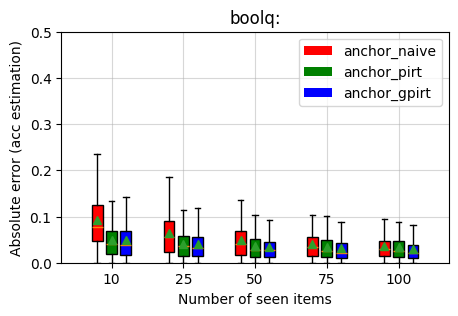

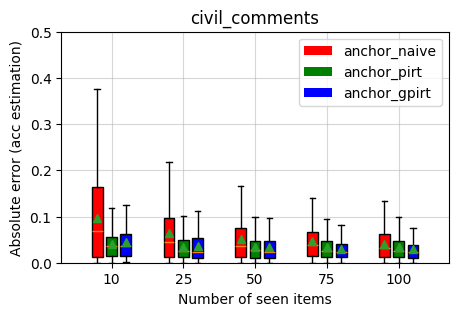

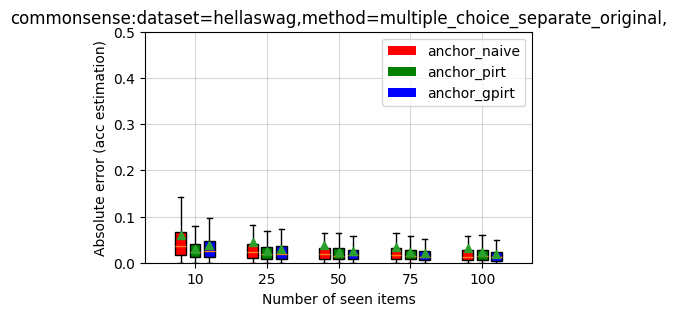

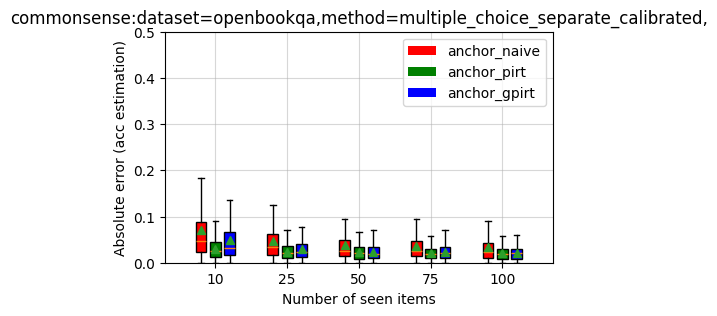

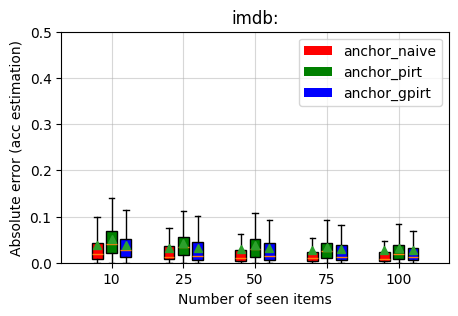

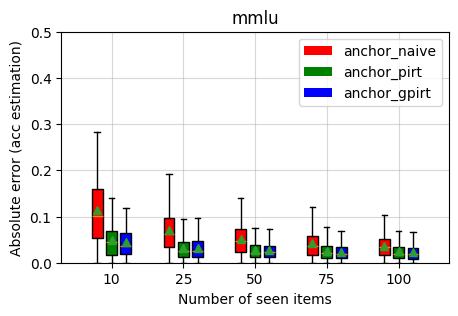

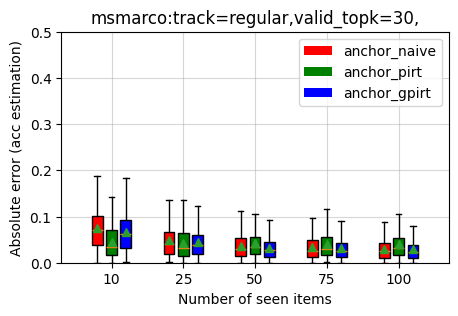

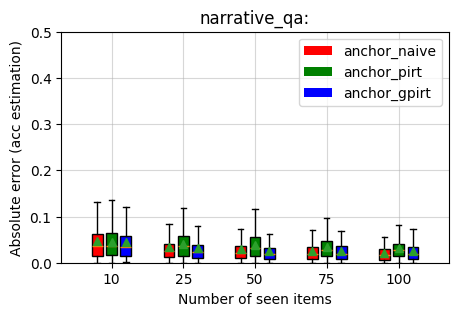

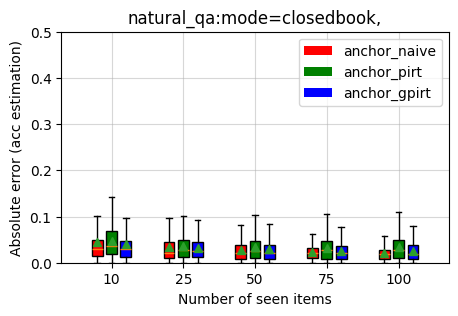

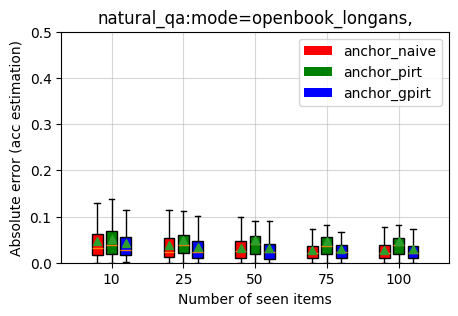

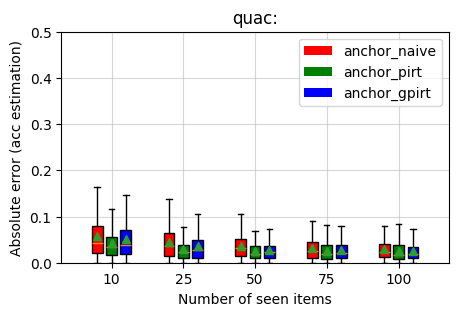

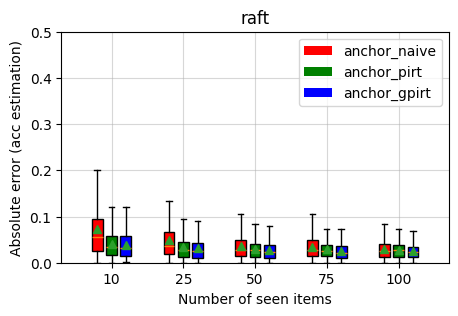

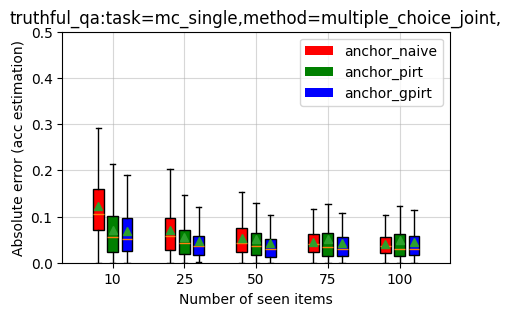

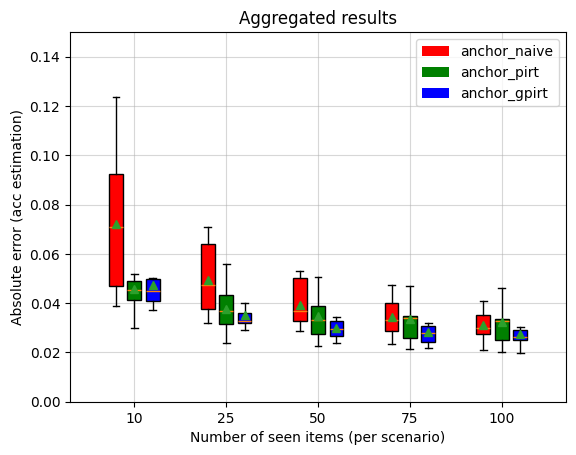

In [7]:
methods = ['anchor_naive', 'anchor_pirt', 'anchor_gpirt']
plot_results(results_full, scenarios.keys(), methods = methods)
plot_agg_results(results_full, scenarios.keys(), methods = methods)

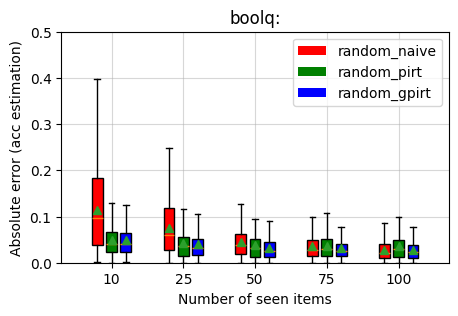

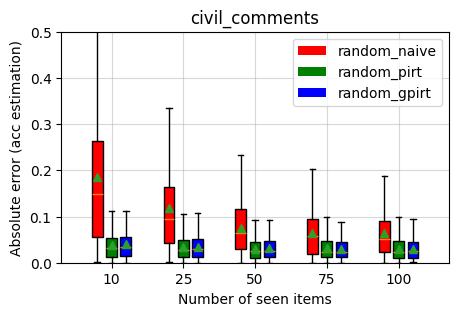

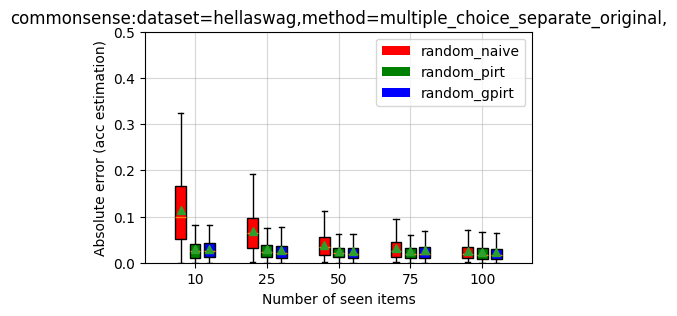

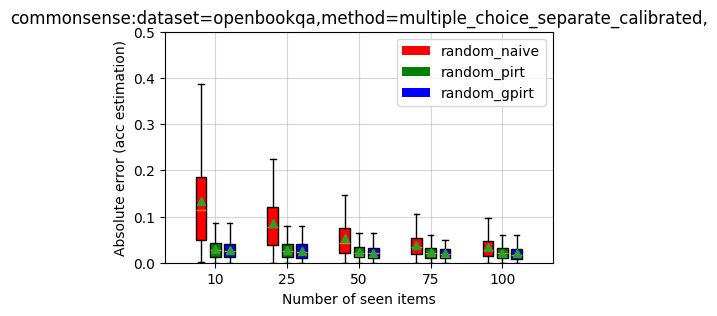

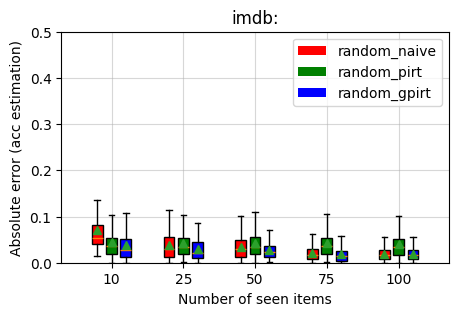

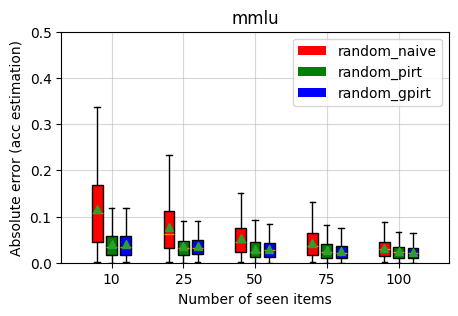

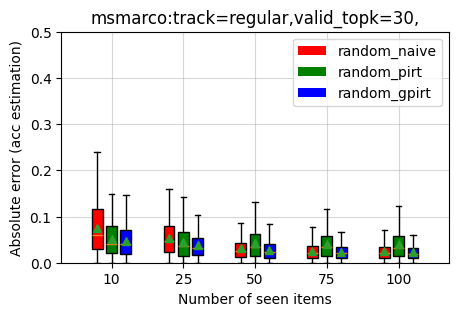

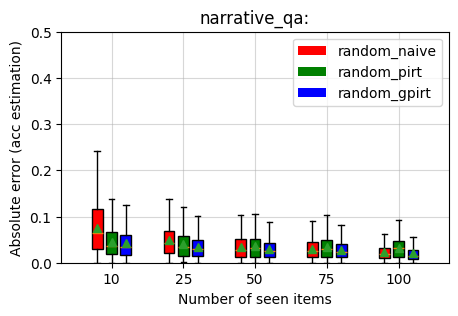

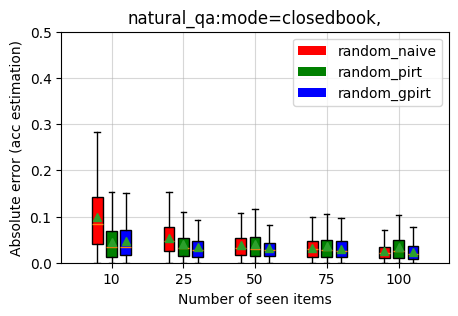

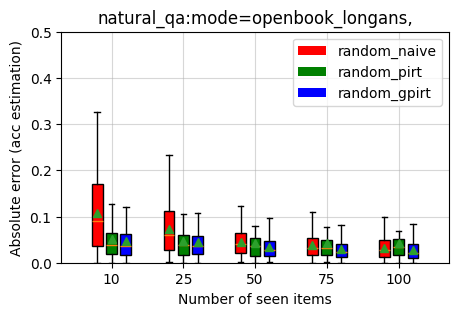

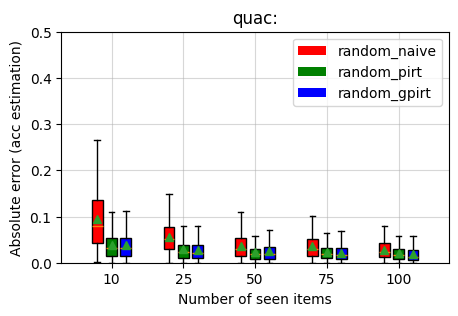

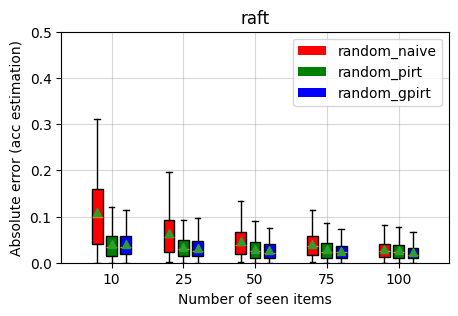

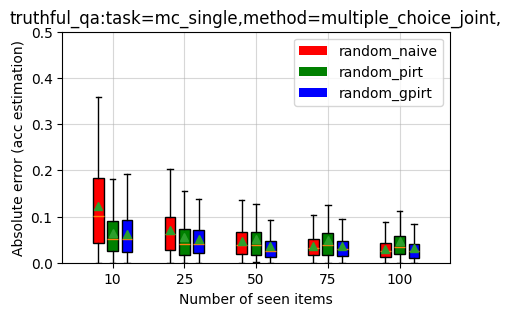

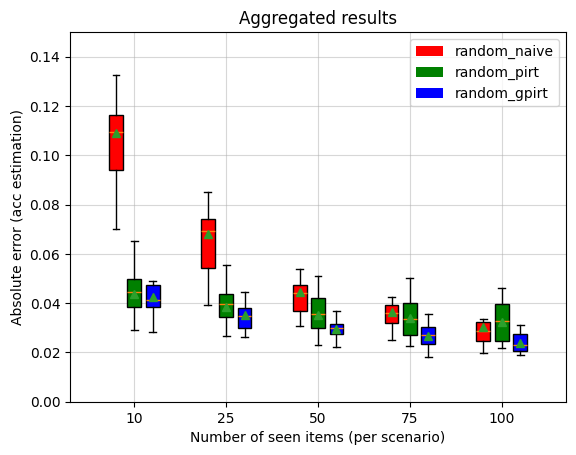

In [8]:
methods = ['random_naive', 'random_pirt', 'random_gpirt']
plot_results(results_full, scenarios.keys(), methods = methods)
plot_agg_results(results_full, scenarios.keys(), methods = methods)

In [11]:
scenarios = {'boolq:':['boolq:'],
             'civil_comments':['civil_comments:demographic=LGBTQ,',
                               'civil_comments:demographic=all,',
                               'civil_comments:demographic=black,',
                               'civil_comments:demographic=christian,',
                               'civil_comments:demographic=female,',
                               'civil_comments:demographic=male,',
                               'civil_comments:demographic=muslim,',
                               'civil_comments:demographic=other_religions,',
                               'civil_comments:demographic=white,'],
             'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':['commonsense:dataset=hellaswag,method=multiple_choice_separate_original,'],
             'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':['commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,'],
             'imdb:':['imdb:'],
             'mmlu':['mmlu:subject=abstract_algebra,method=multiple_choice_joint,',
                     'mmlu:subject=college_chemistry,method=multiple_choice_joint,',
                     'mmlu:subject=computer_security,method=multiple_choice_joint,',
                     'mmlu:subject=econometrics,method=multiple_choice_joint,',
                     'mmlu:subject=us_foreign_policy,method=multiple_choice_joint,'],
             #'msmarco:track=regular,valid_topk=30,':['msmarco:track=regular,valid_topk=30,'],
             #'msmarco:track=trec,valid_topk=30,':['msmarco:track=trec,valid_topk=30,'],
             #'narrative_qa:':['narrative_qa:'],
             #'natural_qa:mode=closedbook,':['natural_qa:mode=closedbook,'],
             #'natural_qa:mode=openbook_longans,':['natural_qa:mode=openbook_longans,'],
             #'quac:':['quac:'],
             'raft':['raft:subset=ade_corpus_v2,',
                     'raft:subset=banking_77,',
                     'raft:subset=neurips_impact_statement_risks,',
                     'raft:subset=one_stop_english,',
                     'raft:subset=overruling,',
                     'raft:subset=semiconductor_org_types,',
                     'raft:subset=systematic_review_inclusion,',
                     'raft:subset=tai_safety_research,',
                     'raft:subset=terms_of_service,',
                     'raft:subset=tweet_eval_hate,',
                     'raft:subset=twitter_complaints,'],
             'truthful_qa:task=mc_single,method=multiple_choice_joint,':['truthful_qa:task=mc_single,method=multiple_choice_joint,']}
            

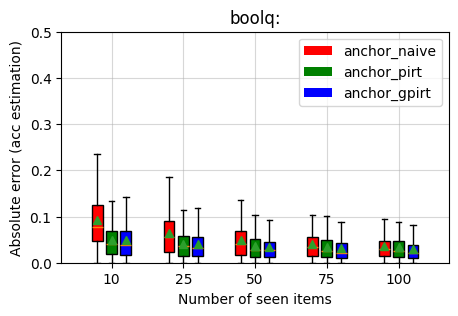

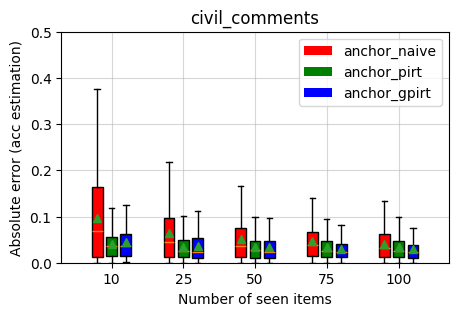

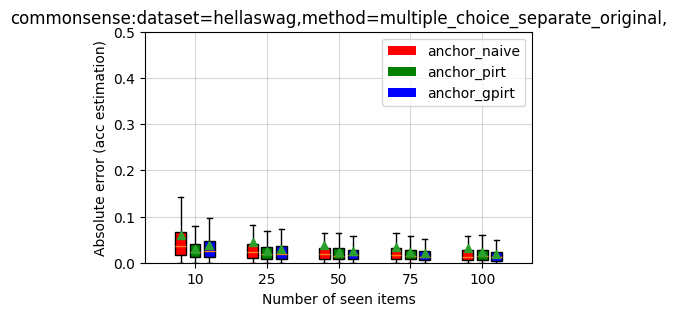

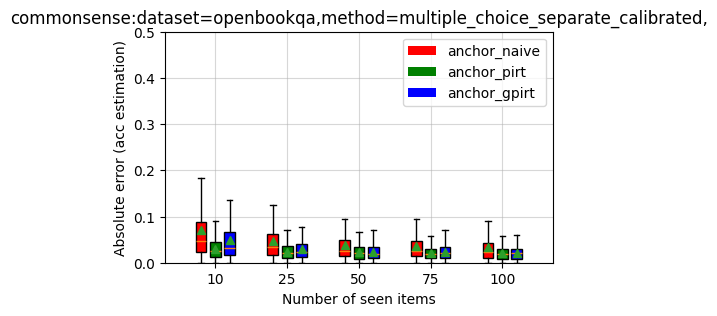

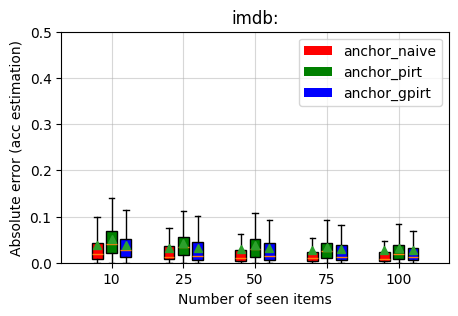

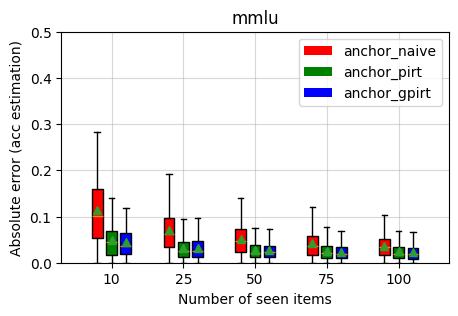

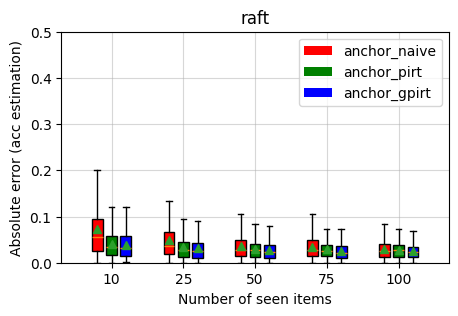

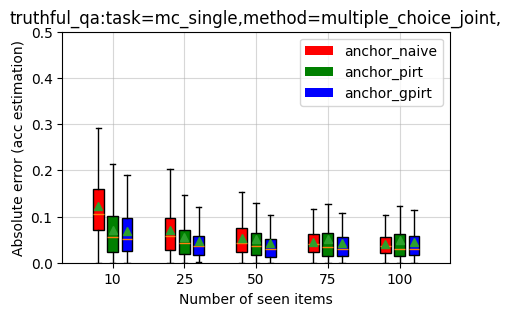

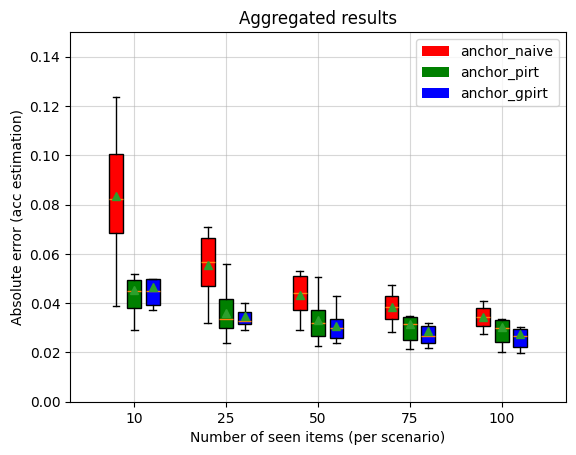

In [12]:
methods = ['anchor_naive', 'anchor_pirt', 'anchor_gpirt']
plot_results(results_full, scenarios.keys(), methods = methods)
plot_agg_results(results_full, scenarios.keys(), methods = methods)

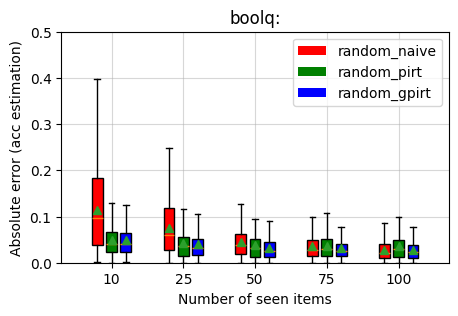

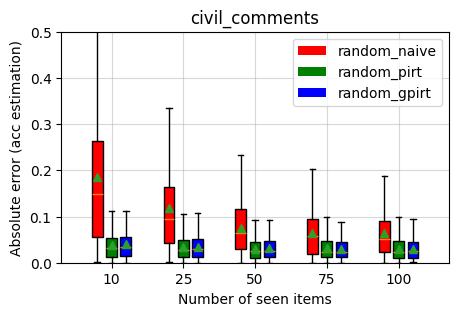

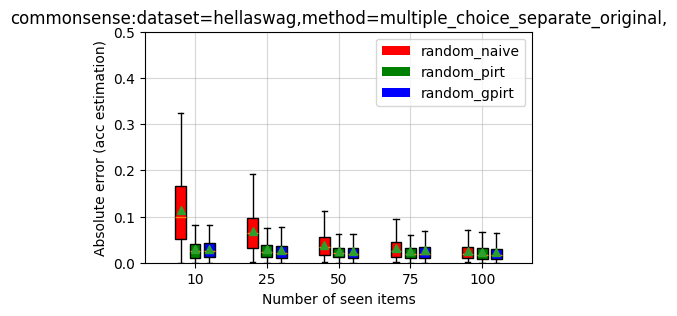

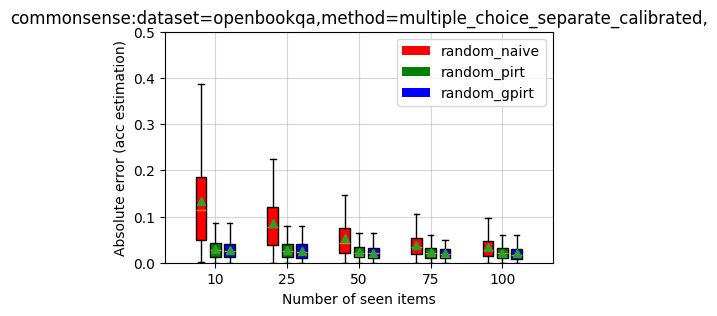

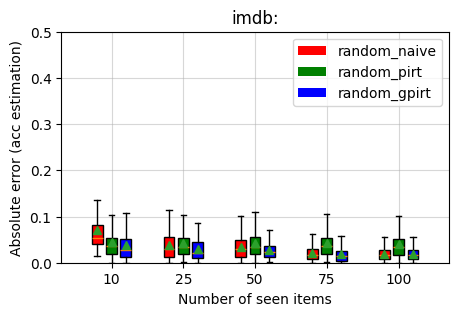

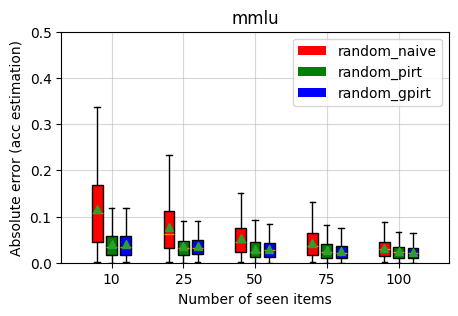

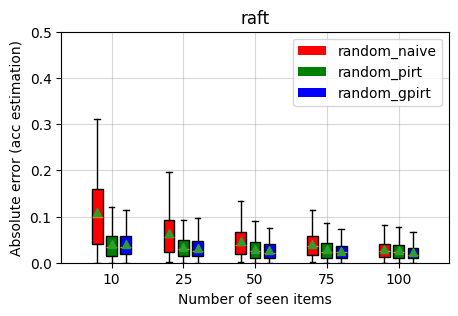

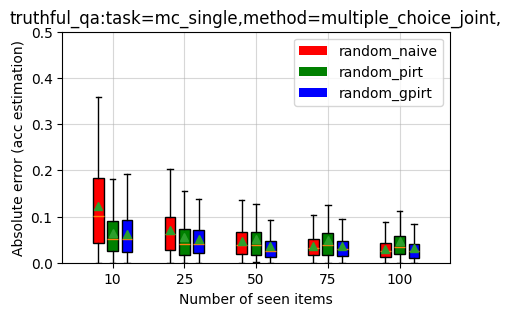

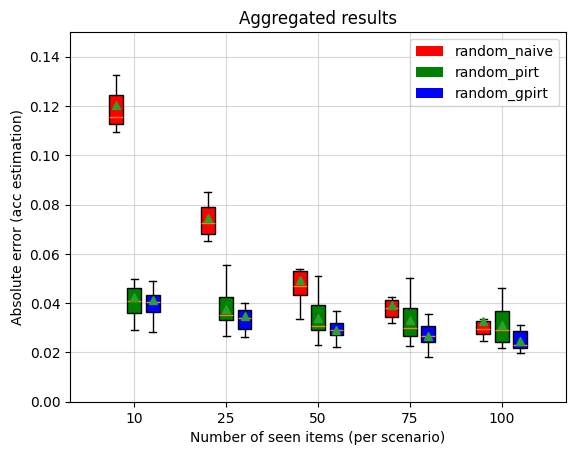

In [13]:
methods = ['random_naive', 'random_pirt', 'random_gpirt']
plot_results(results_full, scenarios.keys(), methods = methods)
plot_agg_results(results_full, scenarios.keys(), methods = methods)

Partial (one IRT model for each scenario)

In [17]:
results_partial = {}
accs_partial = {}

for scenario in scenarios.keys():
    print("\n",scenario,"\n")
    scenario_name = scenario
    chosen_scenarios = [scenario]
    results_partial[scenario], accs_partial[scenario] = evaluate_scenarios(data, scenario_name, chosen_scenarios, scenarios, set_of_rows, Ds, iterations, device)


 boolq: 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [09:08<00:00, 109.67s/it]


- opt D= 5 errors= [0.0391447890028075, 0.01621571456820576, 0.0185528115123623, 0.01749695628662052, 0.019999148709897434] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.85s/it]


{'random_gpirt': {'boolq:': {10: 0.33, 25: 0.33, 50: 0.22, 75: 0.22, 100: 0.22}}, 'anchor_gpirt': {'boolq:': {10: 0.22, 25: 0.33, 50: 0.22, 75: 0.11, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.74s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.68s/it]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [09:15<00:00, 111.11s/it]


- opt D= 5 errors= [0.0313922739011231, 0.015015448766504132, 0.01450887509643007, 0.012725943992798666, 0.020226021633296093] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.49s/it]


{'random_gpirt': {'boolq:': {10: 0.22, 25: 0.33, 50: 0.11, 75: 0.11, 100: 0.22}}, 'anchor_gpirt': {'boolq:': {10: 0.33, 25: 0.33, 50: 0.11, 75: None, 100: 0.0}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.82s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.43s/it]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [09:12<00:00, 110.45s/it]


- opt D= 10 errors= [0.041046555029656526, 0.01998543658593184, 0.019644932606348822, 0.01725720707111006, 0.02169867171640401] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:33<00:00, 33.52s/it]


{'random_gpirt': {'boolq:': {10: 0.0, 25: 0.44, 50: 0.44, 75: 0.33, 100: 0.33}}, 'anchor_gpirt': {'boolq:': {10: 0.0, 25: 0.78, 50: 0.44, 75: 0.33, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:39<00:00,  7.82s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:17<00:00,  4.33s/it]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [09:00<00:00, 108.14s/it]


- opt D= 5 errors= [0.04040352308953419, 0.018225806457008192, 0.019353484194714006, 0.016654260545188544, 0.020374016170767888] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.81s/it]


{'random_gpirt': {'boolq:': {10: 0.11, 25: 0.33, 50: None, 75: None, 100: 0.22}}, 'anchor_gpirt': {'boolq:': {10: 0.44, 25: 0.33, 50: 0.22, 75: 0.11, 100: 0.22}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.02s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.65s/it]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [09:30<00:00, 114.09s/it]


- opt D= 5 errors= [0.07002449306692238, 0.010436097548087442, 0.012218168840212554, 0.01286131684135182, 0.010557985881327711] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.99s/it]


{'random_gpirt': {'boolq:': {10: 0.22, 25: 0.33, 50: 0.22, 75: 0.0, 100: 0.11}}, 'anchor_gpirt': {'boolq:': {10: 0.56, 25: 0.44, 50: 0.22, 75: 0.0, 100: 0.11}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.77s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [08:32<00:00, 102.55s/it]


- opt D= 5 errors= [0.0637253580788669, 0.012978771845211054, 0.013984467379185059, 0.017515333226332475, 0.015911441811084642] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.72s/it]


{'random_gpirt': {'boolq:': {10: 0.11, 25: 0.33, 50: 0.11, 75: 0.22, 100: 0.11}}, 'anchor_gpirt': {'boolq:': {10: 0.56, 25: 0.56, 50: 0.22, 75: 0.11, 100: 0.11}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.91s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:50<00:00, 82.05s/it]


- opt D= 5 errors= [0.07152176037241827, 0.013762314562781847, 0.01305481468436022, 0.016955991199704007, 0.013602226992913094] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.81s/it]


{'random_gpirt': {'boolq:': {10: 0.22, 25: 0.33, 50: 0.11, 75: None, 100: 0.11}}, 'anchor_gpirt': {'boolq:': {10: 0.22, 25: 0.22, 50: 0.0, 75: 0.0, 100: 0.0}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.75s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.60s/it]



 civil_comments 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [07:28<00:00, 89.63s/it]


- opt D= 15 errors= [0.026831194156267786, 0.025913229564857927, 0.02308766410018471, 0.019467244887335436, 0.021502620881776187] 

ii) choosing optimal lambdas


100%|████████████████████████████████████████████| 1/1 [06:35<00:00, 395.15s/it]


{'random_gpirt': {'civil_comments': {10: 0.11, 25: 0.11, 50: 0.11, 75: 0.22, 100: 0.11}}, 'anchor_gpirt': {'civil_comments': {10: None, 25: 0.22, 50: 0.22, 75: 0.44, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [07:56<00:00, 95.24s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [02:58<00:00, 44.55s/it]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [07:25<00:00, 89.14s/it]


- opt D= 10 errors= [0.026369987093603692, 0.021686594737502014, 0.01596784755725887, 0.015549703653883716, 0.017679609078049684] 

ii) choosing optimal lambdas


100%|████████████████████████████████████████████| 1/1 [06:24<00:00, 384.87s/it]


{'random_gpirt': {'civil_comments': {10: 0.11, 25: 0.22, 50: 0.11, 75: 0.22, 100: 0.11}}, 'anchor_gpirt': {'civil_comments': {10: 0.11, 25: 0.78, 50: 0.67, 75: 0.56, 100: 0.44}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [07:59<00:00, 95.83s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [02:36<00:00, 39.06s/it]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [07:36<00:00, 91.37s/it]


- opt D= 5 errors= [0.029874889378432933, 0.015413243647848476, 0.02039392873665693, 0.025588865752400068, 0.02231740924584332] 

ii) choosing optimal lambdas


100%|████████████████████████████████████████████| 1/1 [06:16<00:00, 376.58s/it]


{'random_gpirt': {'civil_comments': {10: 0.11, 25: None, 50: None, 75: 0.0, 100: 0.0}}, 'anchor_gpirt': {'civil_comments': {10: None, 25: 0.22, 50: 0.22, 75: 0.11, 100: 0.11}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [07:50<00:00, 94.20s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [02:26<00:00, 36.50s/it]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [07:44<00:00, 92.87s/it]


- opt D= 5 errors= [0.025577325901824703, 0.015168893660717449, 0.01661615175913611, 0.014342277971019023, 0.014531444457550086] 

ii) choosing optimal lambdas


100%|████████████████████████████████████████████| 1/1 [06:18<00:00, 378.52s/it]


{'random_gpirt': {'civil_comments': {10: None, 25: 0.11, 50: 0.11, 75: None, 100: None}}, 'anchor_gpirt': {'civil_comments': {10: 0.22, 25: 0.22, 50: 0.22, 75: 0.0, 100: 0.11}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [07:52<00:00, 94.55s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [02:25<00:00, 36.27s/it]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [07:22<00:00, 88.43s/it]


- opt D= 5 errors= [0.03739745300229046, 0.021133572277593056, 0.023852730269523274, 0.02284537558902714, 0.019132219769052446] 

ii) choosing optimal lambdas


100%|████████████████████████████████████████████| 1/1 [06:17<00:00, 377.87s/it]


{'random_gpirt': {'civil_comments': {10: 0.11, 25: 0.11, 50: None, 75: 0.11, 100: 0.11}}, 'anchor_gpirt': {'civil_comments': {10: None, 25: 0.22, 50: None, 75: 0.11, 100: 0.11}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [07:46<00:00, 93.40s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [02:25<00:00, 36.42s/it]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [07:47<00:00, 93.59s/it]


- opt D= 20 errors= [0.026137350215419006, 0.02409623984570715, 0.023738132777932512, 0.02449037824930894, 0.020525789240202666] 

ii) choosing optimal lambdas


100%|████████████████████████████████████████████| 1/1 [06:53<00:00, 413.73s/it]


{'random_gpirt': {'civil_comments': {10: None, 25: 0.33, 50: 0.56, 75: 0.56, 100: 0.44}}, 'anchor_gpirt': {'civil_comments': {10: 0.56, 25: 0.33, 50: 0.44, 75: 0.67, 100: 0.67}}}
iii) running anchor points


100%|████████████████████████████████████████████| 5/5 [08:32<00:00, 102.57s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [03:04<00:00, 46.09s/it]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [07:57<00:00, 95.44s/it]


- opt D= 20 errors= [0.03605521919090106, 0.026244925665941166, 0.02468131577444542, 0.022102492226258832, 0.0168919197602862] 

ii) choosing optimal lambdas


100%|████████████████████████████████████████████| 1/1 [07:06<00:00, 426.36s/it]


{'random_gpirt': {'civil_comments': {10: 0.11, 25: 0.33, 50: 0.44, 75: 0.56, 100: 0.44}}, 'anchor_gpirt': {'civil_comments': {10: None, 25: 0.44, 50: 0.67, 75: 0.56, 100: 0.67}}}
iii) running anchor points


100%|████████████████████████████████████████████| 5/5 [08:25<00:00, 101.03s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [03:06<00:00, 46.56s/it]



 commonsense:dataset=hellaswag,method=multiple_choice_separate_original, 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:31<00:00, 78.27s/it]


- opt D= 1 errors= [0.013472925984166564, 0.013104313905484291, 0.013412802484092365, 0.020320570492779202, 0.01792893832742705] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.21s/it]


{'random_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.0, 25: 0.0, 50: 0.11, 75: None, 100: 0.22}}, 'anchor_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.78, 25: 0.11, 50: 0.22, 75: 0.22, 100: 0.44}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.62s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.58it/s]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:24<00:00, 76.90s/it]


- opt D= 5 errors= [0.019220950893035882, 0.010840834681311404, 0.0142228312366834, 0.0147472500589374, 0.01288087428407271] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:23<00:00, 23.97s/it]


{'random_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.11, 25: 0.22, 50: 0.22, 75: None, 100: 0.22}}, 'anchor_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.78, 25: 0.44, 50: None, 75: 0.22, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.69s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.21s/it]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:35<00:00, 79.09s/it]


- opt D= 15 errors= [0.019651646790248542, 0.010994913921398258, 0.010771853460795414, 0.007922663315184555, 0.015428543756502239] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:45<00:00, 45.60s/it]


{'random_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.11, 25: 0.33, 50: 0.44, 75: 0.22, 100: 0.33}}, 'anchor_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.56, 25: 0.78, 50: 0.56, 75: 0.44, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:56<00:00, 11.25s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:44<00:00, 11.24s/it]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:34<00:00, 78.91s/it]


- opt D= 10 errors= [0.020549749953339233, 0.011882981031137552, 0.008711860919513412, 0.010344737702241702, 0.015311047453643103] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:34<00:00, 34.12s/it]


{'random_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.22, 100: 0.33}}, 'anchor_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.56, 25: 0.56, 50: None, 75: 0.22, 100: 0.44}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:38<00:00,  7.62s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:19<00:00,  4.88s/it]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:32<00:00, 78.45s/it]


- opt D= 5 errors= [0.021434359034450692, 0.009061093390205666, 0.00957492916773428, 0.006751278193939128, 0.008581857915584495] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.57s/it]


{'random_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.22, 25: 0.33, 50: 0.11, 75: 0.0, 100: 0.0}}, 'anchor_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.89, 25: 0.67, 50: 0.33, 75: 0.22, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.45s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.62s/it]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:37<00:00, 79.46s/it]


- opt D= 5 errors= [0.018866070412556293, 0.009355615582313355, 0.00903054948325517, 0.01014578296108807, 0.011795709173033346] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:23<00:00, 23.04s/it]


{'random_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.33, 25: 0.33, 50: 0.11, 75: 0.0, 100: 0.11}}, 'anchor_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.78, 25: 0.56, 50: 0.33, 75: 0.33, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.83s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.94s/it]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:31<00:00, 78.33s/it]


- opt D= 5 errors= [0.015437634315892311, 0.009154554061049897, 0.007710795480093763, 0.01002886763071014, 0.0073689973264155564] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.15s/it]


{'random_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.22, 25: 0.11, 50: None, 75: None, 100: 0.11}}, 'anchor_gpirt': {'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.67, 25: 0.44, 50: 0.22, 75: 0.44, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.83s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.11s/it]



 commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated, 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:19<00:00, 75.83s/it]


- opt D= 10 errors= [0.02743432308877819, 0.028244580766852392, 0.023290139496623917, 0.028921938828032158, 0.03363503079886196] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.45s/it]


{'random_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.22, 25: 0.44, 50: 0.22, 75: 0.22, 100: 0.11}}, 'anchor_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 1.0, 25: 0.67, 50: 0.22, 75: 0.44, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:33<00:00,  6.77s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:12<00:00,  3.02s/it]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:29<00:00, 77.80s/it]


- opt D= 1 errors= [0.020277426544103222, 0.027688926386849347, 0.018887151874080868, 0.02985141206718657, 0.031570787297650414] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.93s/it]


{'random_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.0, 25: 0.11, 50: 0.11, 75: 0.22, 100: 0.22}}, 'anchor_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.22, 25: 0.11, 50: None, 75: 0.22, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:16<00:00,  3.26s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.34it/s]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:31<00:00, 78.24s/it]


- opt D= 1 errors= [0.024841790013841625, 0.03248805183468519, 0.02884756562062881, 0.03926899091806934, 0.0353146757394444] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.82s/it]


{'random_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.0, 25: 0.11, 50: 0.11, 75: 0.22, 100: 0.22}}, 'anchor_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.44, 25: 0.11, 50: 0.22, 75: None, 100: None}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.72s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.18it/s]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:26<00:00, 77.27s/it]


- opt D= 1 errors= [0.026052891527093537, 0.029693898689961612, 0.023937180020158134, 0.03161114014514607, 0.032413769921771134] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.31s/it]


{'random_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.11, 25: 0.22, 50: 0.11, 75: 0.33, 100: 0.22}}, 'anchor_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.22, 25: 0.11, 50: 0.11, 75: 0.33, 100: 0.44}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.61s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.08it/s]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:26<00:00, 77.27s/it]


- opt D= 1 errors= [0.02880166442835331, 0.027330996918349615, 0.027972512969625732, 0.03514129745961206, 0.027159196318479795] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.14s/it]


{'random_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.11, 25: 0.11, 50: 0.11, 75: 0.22, 100: 0.33}}, 'anchor_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.44, 25: 0.22, 50: 0.22, 75: 0.0, 100: 0.11}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.52s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.37it/s]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:08<00:00, 73.80s/it]


- opt D= 1 errors= [0.02211615404375103, 0.021378808701628192, 0.026576462413205965, 0.03301392518331869, 0.037621768343447666] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.37s/it]


{'random_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: None, 25: 0.33, 50: 0.11, 75: 0.33, 100: 0.33}}, 'anchor_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.11, 25: 0.0, 50: None, 75: 0.22, 100: 0.22}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.82s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.33it/s]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:23<00:00, 76.64s/it]


- opt D= 1 errors= [0.025617408705280544, 0.027735364383573796, 0.0297021597725717, 0.03178774650686481, 0.026648792714569394] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.69s/it]


{'random_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: None, 25: 0.33, 50: 0.22, 75: 0.33, 100: 0.22}}, 'anchor_gpirt': {'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.22, 25: 0.11, 50: 0.22, 75: None, 100: 0.22}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.59s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.26it/s]



 imdb: 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [09:03<00:00, 108.71s/it]


- opt D= 5 errors= [0.030482732358319733, 0.005898308152725018, 0.009324578552109608, 0.006478050161777826, 0.006303034612034311] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.47s/it]


{'random_gpirt': {'imdb:': {10: 0.0, 25: 0.22, 50: 0.22, 75: 0.33, 100: 0.33}}, 'anchor_gpirt': {'imdb:': {10: 0.44, 25: 0.56, 50: 0.22, 75: 1.0, 100: 1.0}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:36<00:00,  7.22s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:14<00:00,  3.68s/it]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [10:12<00:00, 122.53s/it]


- opt D= 5 errors= [0.02949886942966219, 0.006449803734967202, 0.010421031052222654, 0.006864301302692777, 0.009534533477678964] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.81s/it]


{'random_gpirt': {'imdb:': {10: 0.0, 25: 0.22, 50: 0.22, 75: 0.33, 100: 0.44}}, 'anchor_gpirt': {'imdb:': {10: 0.22, 25: 0.22, 50: 0.11, 75: 0.22, 100: 1.0}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.36s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:12<00:00,  3.25s/it]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [10:05<00:00, 121.14s/it]


- opt D= 20 errors= [0.02468741003388425, 0.012626145563524954, 0.012488526060343619, 0.017119290182561794, 0.004851305220777938] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [01:00<00:00, 60.37s/it]


{'random_gpirt': {'imdb:': {10: 0.11, 25: 0.22, 50: 0.44, 75: 0.56, 100: 0.78}}, 'anchor_gpirt': {'imdb:': {10: 0.44, 25: 0.78, 50: 0.89, 75: 0.89, 100: 0.78}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [01:42<00:00, 20.41s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [01:08<00:00, 17.05s/it]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [10:29<00:00, 125.98s/it]


- opt D= 10 errors= [0.03341070734975134, 0.02468667925557895, 0.015153972422234749, 0.01272286009163097, 0.014984737911290902] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:37<00:00, 37.54s/it]


{'random_gpirt': {'imdb:': {10: 0.0, 25: 0.22, 50: 0.44, 75: 0.44, 100: 0.56}}, 'anchor_gpirt': {'imdb:': {10: 0.78, 25: 0.89, 50: 0.89, 75: 1.0, 100: 1.0}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:50<00:00, 10.00s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:24<00:00,  6.01s/it]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [09:17<00:00, 111.44s/it]


- opt D= 10 errors= [0.020412558729408253, 0.009269404894256358, 0.005302195607224197, 0.008352550358155894, 0.012345160211623726] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:39<00:00, 39.44s/it]


{'random_gpirt': {'imdb:': {10: 0.22, 25: 0.44, 50: 0.56, 75: 0.44, 100: 0.44}}, 'anchor_gpirt': {'imdb:': {10: 0.67, 25: 0.78, 50: 0.67, 75: 0.33, 100: 0.22}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:42<00:00,  8.52s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:23<00:00,  5.92s/it]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [07:29<00:00, 89.89s/it]


- opt D= 5 errors= [0.02739887837870865, 0.007791422414773139, 0.01067758000863403, 0.017271065127986082, 0.016199791880473893] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:39<00:00, 39.95s/it]


{'random_gpirt': {'imdb:': {10: 0.22, 25: 0.44, 50: 0.22, 75: 0.22, 100: 0.22}}, 'anchor_gpirt': {'imdb:': {10: 0.56, 25: 0.56, 50: 0.44, 75: 0.44, 100: 0.44}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:34<00:00,  7.00s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.25s/it]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:36<00:00, 79.29s/it]


- opt D= 5 errors= [0.013877330295414242, 0.006909211122052686, 0.009057544857314734, 0.012223981086037186, 0.01224187734660169] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:39<00:00, 39.07s/it]


{'random_gpirt': {'imdb:': {10: None, 25: 0.33, 50: 0.22, 75: 0.22, 100: 0.22}}, 'anchor_gpirt': {'imdb:': {10: 0.56, 25: 0.22, 50: 0.11, 75: 0.44, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:37<00:00,  7.45s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:12<00:00,  3.14s/it]



 mmlu 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:30<00:00, 78.16s/it]


- opt D= 1 errors= [0.03178931321254619, 0.029304447956289673, 0.029301526177259708, 0.03210328700327825, 0.030164377750967607] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.32s/it]


{'random_gpirt': {'mmlu': {10: 0.11, 25: None, 50: 0.22, 75: 0.33, 100: 0.22}}, 'anchor_gpirt': {'mmlu': {10: 0.0, 25: 0.0, 50: 0.11, 75: 0.22, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.16s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:29<00:00, 77.99s/it]


- opt D= 1 errors= [0.022656866880381547, 0.026724152033478506, 0.02917572771760844, 0.03313694279979333, 0.034004559604389] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.88s/it]


{'random_gpirt': {'mmlu': {10: None, 25: 0.11, 50: 0.22, 75: 0.22, 100: 0.11}}, 'anchor_gpirt': {'mmlu': {10: 0.0, 25: 0.0, 50: None, 75: 0.11, 100: None}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.14s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:32<00:00, 78.46s/it]


- opt D= 1 errors= [0.0218273580671109, 0.029884546976325616, 0.02720675506502004, 0.028592921119446876, 0.028741879486531355] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.94s/it]


{'random_gpirt': {'mmlu': {10: None, 25: 0.0, 50: 0.22, 75: 0.0, 100: 0.11}}, 'anchor_gpirt': {'mmlu': {10: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 100: 0.11}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:21<00:00,  4.20s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:21<00:00, 76.36s/it]


- opt D= 1 errors= [0.02202811862506446, 0.024033562142728736, 0.032082979189929736, 0.029425088591199102, 0.02150547204452031] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.95s/it]


{'random_gpirt': {'mmlu': {10: 0.0, 25: 0.11, 50: 0.22, 75: None, 100: 0.22}}, 'anchor_gpirt': {'mmlu': {10: 0.0, 25: 0.0, 50: 0.0, 75: None, 100: 0.11}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.10s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:22<00:00, 76.56s/it]


- opt D= 1 errors= [0.020915295491759116, 0.03715741907036073, 0.02780616099066257, 0.03612227444626912, 0.02780763967844244] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.29s/it]


{'random_gpirt': {'mmlu': {10: None, 25: 0.0, 50: 0.11, 75: 0.0, 100: 0.11}}, 'anchor_gpirt': {'mmlu': {10: 0.11, 25: 0.11, 50: 0.0, 75: 0.0, 100: 0.0}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:21<00:00,  4.28s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:28<00:00, 77.71s/it]


- opt D= 1 errors= [0.017410829630884195, 0.029865643111660335, 0.024860992994193434, 0.02994174171883823, 0.03015664062454223] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.98s/it]


{'random_gpirt': {'mmlu': {10: 0.11, 25: 0.11, 50: 0.22, 75: None, 100: 0.22}}, 'anchor_gpirt': {'mmlu': {10: 0.0, 25: 0.11, 50: None, 75: 0.11, 100: 0.22}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.16s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:28<00:00, 77.63s/it]


- opt D= 10 errors= [0.03994523967817576, 0.03655204462422024, 0.026363226032257454, 0.0282702911945526, 0.0379646620462724] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.05s/it]


{'random_gpirt': {'mmlu': {10: 0.56, 25: 0.67, 50: 0.33, 75: 0.22, 100: 0.33}}, 'anchor_gpirt': {'mmlu': {10: 0.56, 25: 0.56, 50: 0.22, 75: 0.22, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:35<00:00,  7.03s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:13<00:00,  3.44s/it]



 msmarco:track=regular,valid_topk=30, 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:36<00:00, 79.21s/it]


- opt D= 5 errors= [0.01782994599264586, 0.01472848472117462, 0.026708219096090658, 0.03055267606440924, 0.04193769279516396] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.02s/it]


{'random_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 1.0, 25: 0.67, 50: 0.89, 75: 0.89, 100: 1.0}}, 'anchor_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 0.89, 25: 0.78, 50: 0.67, 75: 0.78, 100: 0.78}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.52s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/it]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:34<00:00, 78.94s/it]


- opt D= 5 errors= [0.027634421452855357, 0.019977001487861357, 0.02599170361473092, 0.03293034106293198, 0.06702794137918527] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:33<00:00, 33.05s/it]


{'random_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 1.0, 25: 0.78, 50: 0.89, 75: 0.89, 100: 1.0}}, 'anchor_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 0.89, 25: 0.44, 50: 0.33, 75: 0.44, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:33<00:00,  6.73s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.49s/it]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:32<00:00, 78.57s/it]


- opt D= 5 errors= [0.02983871360236024, 0.02031255892769609, 0.03147283775790326, 0.03890671177423999, 0.03818717255229984] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.74s/it]


{'random_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 1.0, 25: 0.67, 50: 0.89, 75: 0.89, 100: 1.0}}, 'anchor_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 0.89, 25: 0.44, 50: 0.56, 75: 0.56, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.46s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.70s/it]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:37<00:00, 79.45s/it]


- opt D= 5 errors= [0.026501067857886113, 0.016389843410326364, 0.02096813038935981, 0.028352399787898417, 0.047615223097036516] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.32s/it]


{'random_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 1.0, 25: 0.67, 50: 0.89, 75: 0.89, 100: 1.0}}, 'anchor_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 0.78, 25: 0.67, 50: 0.56, 75: 0.67, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.71s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.91s/it]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:46<00:00, 81.30s/it]


- opt D= 1 errors= [0.02593611339677363, 0.024162421567595686, 0.02591396915611241, 0.03446524801388766, 0.04883268666366787] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.50s/it]


{'random_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 0.67, 25: 0.67, 50: 0.78, 75: 0.78, 100: 0.89}}, 'anchor_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 0.67, 25: 0.67, 50: 0.56, 75: 0.78, 100: 0.78}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.64s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:49<00:00, 81.95s/it]


- opt D= 5 errors= [0.03064788646050487, 0.027948286348612503, 0.031174817798285133, 0.034280261791061854, 0.05681791861769544] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.51s/it]


{'random_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 1.0, 25: 0.67, 50: 0.89, 75: 0.78, 100: 1.0}}, 'anchor_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 0.89, 25: 0.67, 50: 0.56, 75: 0.67, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:26<00:00,  5.38s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.50s/it]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:58<00:00, 83.61s/it]


- opt D= 10 errors= [0.0311011898800571, 0.029103327447323697, 0.02141667363985237, 0.02509668453581164, 0.055547980253751905] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:33<00:00, 33.25s/it]


{'random_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 0.89, 25: 0.78, 50: 0.67, 75: 0.67, 100: 0.78}}, 'anchor_gpirt': {'msmarco:track=regular,valid_topk=30,': {10: 0.89, 25: 0.89, 50: 0.78, 75: 0.67, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:35<00:00,  7.11s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:14<00:00,  3.71s/it]



 narrative_qa: 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:48<00:00, 81.68s/it]


- opt D= 1 errors= [0.023085030156204424, 0.029033293147614596, 0.033705472698380104, 0.03435322962004337, 0.041171888758492134] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.36s/it]


{'random_gpirt': {'narrative_qa:': {10: 0.56, 25: 0.56, 50: 0.56, 75: 0.44, 100: 0.67}}, 'anchor_gpirt': {'narrative_qa:': {10: 1.0, 25: 0.89, 50: 0.67, 75: 0.56, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.45s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.27it/s]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:44<00:00, 80.98s/it]


- opt D= 1 errors= [0.025025826202195206, 0.02489858828199465, 0.02778238282994929, 0.029475937293981888, 0.045749329813405515] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.26s/it]


{'random_gpirt': {'narrative_qa:': {10: 0.56, 25: 0.67, 50: 0.56, 75: 0.56, 100: 0.67}}, 'anchor_gpirt': {'narrative_qa:': {10: 1.0, 25: 0.89, 50: 0.78, 75: 0.78, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.74s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.34it/s]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:59<00:00, 84.00s/it]


- opt D= 1 errors= [0.032840194650276294, 0.033919098795224464, 0.033138922921209256, 0.0393121411875788, 0.04684285944665112] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.32s/it]


{'random_gpirt': {'narrative_qa:': {10: 0.44, 25: 0.67, 50: 0.56, 75: 0.44, 100: 0.67}}, 'anchor_gpirt': {'narrative_qa:': {10: 1.0, 25: 0.78, 50: 0.78, 75: 0.67, 100: 0.44}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:16<00:00,  3.32s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.62it/s]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:48<00:00, 81.77s/it]


- opt D= 10 errors= [0.03538596589991305, 0.042752672422845486, 0.03205654596551802, 0.03700344799461031, 0.04541126646927816] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.22s/it]


{'random_gpirt': {'narrative_qa:': {10: 0.67, 25: 0.89, 50: 0.67, 75: 0.56, 100: 0.67}}, 'anchor_gpirt': {'narrative_qa:': {10: 1.0, 25: 0.78, 50: 0.67, 75: 0.44, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:35<00:00,  7.11s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:19<00:00,  4.78s/it]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:46<00:00, 81.35s/it]


- opt D= 10 errors= [0.019841797657404306, 0.028763982448347193, 0.01558481483515571, 0.030306765924468272, 0.03085294298842301] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.12s/it]


{'random_gpirt': {'narrative_qa:': {10: 0.44, 25: 0.78, 50: 0.67, 75: 0.56, 100: 0.56}}, 'anchor_gpirt': {'narrative_qa:': {10: 0.89, 25: 0.89, 50: 0.78, 75: 0.56, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:34<00:00,  6.80s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:16<00:00,  4.19s/it]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:53<00:00, 82.65s/it]


- opt D= 15 errors= [0.019802538427199708, 0.02306002416595173, 0.018056224056520534, 0.013639829603045661, 0.031669038729544144] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:40<00:00, 40.89s/it]


{'random_gpirt': {'narrative_qa:': {10: 0.56, 25: 0.78, 50: 0.89, 75: 0.67, 100: 0.67}}, 'anchor_gpirt': {'narrative_qa:': {10: 0.89, 25: 0.89, 50: 0.89, 75: 0.67, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:43<00:00,  8.73s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:28<00:00,  7.14s/it]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:58<00:00, 83.74s/it]


- opt D= 10 errors= [0.030489766753143854, 0.03171371064507636, 0.020410853076148802, 0.019398250015600305, 0.024677066303917344] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.44s/it]


{'random_gpirt': {'narrative_qa:': {10: 0.56, 25: 0.78, 50: 0.78, 75: 0.67, 100: 0.67}}, 'anchor_gpirt': {'narrative_qa:': {10: 0.78, 25: 1.0, 50: 0.78, 75: 0.67, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:34<00:00,  6.95s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:16<00:00,  4.10s/it]



 natural_qa:mode=closedbook, 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:54<00:00, 82.95s/it]


- opt D= 1 errors= [0.012212871569625241, 0.011560328951627062, 0.011793112394970598, 0.015853082415517344, 0.013777445565956978] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.85s/it]


{'random_gpirt': {'natural_qa:mode=closedbook,': {10: 0.11, 25: 0.11, 50: 0.22, 75: 0.33, 100: 0.33}}, 'anchor_gpirt': {'natural_qa:mode=closedbook,': {10: 0.89, 25: 0.56, 50: 0.11, 75: 0.33, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.79s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:51<00:00, 82.24s/it]


- opt D= 1 errors= [0.01276324880083391, 0.013623946449167116, 0.01588935775682821, 0.016460689391557454, 0.01353129807161363] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.15s/it]


{'random_gpirt': {'natural_qa:mode=closedbook,': {10: 0.22, 25: 0.22, 50: 0.22, 75: 0.33, 100: 0.33}}, 'anchor_gpirt': {'natural_qa:mode=closedbook,': {10: 0.89, 25: 0.33, 50: 0.0, 75: 0.44, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.85s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:53<00:00, 82.75s/it]


- opt D= 1 errors= [0.009371545908095604, 0.008586185512700333, 0.01133794695882457, 0.019110324290597853, 0.019725464686378365] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:23<00:00, 23.19s/it]


{'random_gpirt': {'natural_qa:mode=closedbook,': {10: 0.22, 25: 0.33, 50: 0.11, 75: 0.44, 100: 0.33}}, 'anchor_gpirt': {'natural_qa:mode=closedbook,': {10: 0.67, 25: 0.22, 50: None, 75: 0.33, 100: 0.44}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.77s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:44<00:00, 80.86s/it]


- opt D= 1 errors= [0.011462598267547891, 0.010605410081884321, 0.012408135117492758, 0.017460893707734272, 0.023531270691974554] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.27s/it]


{'random_gpirt': {'natural_qa:mode=closedbook,': {10: 0.22, 25: 0.33, 50: 0.22, 75: 0.44, 100: 0.33}}, 'anchor_gpirt': {'natural_qa:mode=closedbook,': {10: 0.56, 25: 0.56, 50: 0.44, 75: 0.22, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.70s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:27<00:00, 77.54s/it]


- opt D= 1 errors= [0.011647608097600825, 0.015505872717560633, 0.017328556676157125, 0.023068572276728122, 0.024819305113193475] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 22.00s/it]


{'random_gpirt': {'natural_qa:mode=closedbook,': {10: 0.22, 25: 0.22, 50: 0.22, 75: 0.33, 100: 0.33}}, 'anchor_gpirt': {'natural_qa:mode=closedbook,': {10: 0.56, 25: 0.11, 50: 0.11, 75: 0.22, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.62s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:51<00:00, 82.30s/it]


- opt D= 1 errors= [0.012400423180505906, 0.015608662446462198, 0.015548942265069799, 0.022039444165259072, 0.010737124970471724] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.47s/it]


{'random_gpirt': {'natural_qa:mode=closedbook,': {10: 0.22, 25: 0.22, 50: 0.22, 75: 0.44, 100: 0.44}}, 'anchor_gpirt': {'natural_qa:mode=closedbook,': {10: 0.67, 25: 0.33, 50: 0.44, 75: 0.44, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.91s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:48<00:00, 81.69s/it]


- opt D= 1 errors= [0.012504195493168007, 0.013752350198624495, 0.014945213368000159, 0.01748435938278748, 0.02095283251752785] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.95s/it]


{'random_gpirt': {'natural_qa:mode=closedbook,': {10: 0.11, 25: 0.22, 50: 0.22, 75: 0.33, 100: 0.44}}, 'anchor_gpirt': {'natural_qa:mode=closedbook,': {10: 0.67, 25: 0.33, 50: 0.22, 75: 0.33, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.81s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]



 natural_qa:mode=openbook_longans, 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:58<00:00, 83.80s/it]


- opt D= 5 errors= [0.025257993928542985, 0.0212592991742145, 0.025007419704137557, 0.021958124709845254, 0.023477854169533907] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.38s/it]


{'random_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.56, 25: 0.67, 50: 0.44, 75: 0.56, 100: 0.56}}, 'anchor_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.89, 25: 1.0, 50: 0.89, 75: 0.67, 100: 0.78}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.86s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.92s/it]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:59<00:00, 83.92s/it]


- opt D= 1 errors= [0.033887304615907346, 0.03204921845132195, 0.03288098342349717, 0.033297937802916976, 0.03252758496286472] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.54s/it]


{'random_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.33, 25: 0.44, 50: 0.44, 75: 0.44, 100: 0.56}}, 'anchor_gpirt': {'natural_qa:mode=openbook_longans,': {10: 1.0, 25: 0.67, 50: 0.56, 75: 1.0, 100: 1.0}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.80s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:49<00:00, 81.82s/it]


- opt D= 1 errors= [0.02929005303091134, 0.030827175190170836, 0.034730389164783625, 0.03252386526998192, 0.032641596434270746] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.17s/it]


{'random_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.44, 25: 0.44, 50: 0.44, 75: 0.44, 100: 0.44}}, 'anchor_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.67, 25: 0.67, 50: 0.56, 75: 0.44, 100: 0.78}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:22<00:00,  4.53s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:49<00:00, 81.81s/it]


- opt D= 10 errors= [0.03341482181078299, 0.03244175158299006, 0.02786738332393498, 0.03242206988207749, 0.027775652253612837] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:36<00:00, 36.22s/it]


{'random_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.44, 25: 0.56, 50: 0.67, 75: 0.56, 100: 0.56}}, 'anchor_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.67, 25: 0.67, 50: 0.56, 75: 0.67, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:37<00:00,  7.52s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:17<00:00,  4.28s/it]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:57<00:00, 83.56s/it]


- opt D= 1 errors= [0.03332748918409164, 0.033424639903504125, 0.0394304556360059, 0.03298275765471466, 0.03422266527135582] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.11s/it]


{'random_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.33, 25: 0.44, 50: 0.33, 75: 0.44, 100: 0.44}}, 'anchor_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.44, 25: 0.44, 50: 0.56, 75: 0.56, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.78s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:57<00:00, 83.57s/it]


- opt D= 15 errors= [0.042345284581178366, 0.04048308711586411, 0.040857383642168545, 0.030088515004007388, 0.04747068333610295] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:49<00:00, 49.05s/it]


{'random_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.44, 25: 0.67, 50: 0.56, 75: 0.44, 100: 0.56}}, 'anchor_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.89, 25: 0.78, 50: 0.67, 75: 0.78, 100: 0.89}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:55<00:00, 11.14s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:40<00:00, 10.02s/it]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:28<00:00, 77.63s/it]


- opt D= 5 errors= [0.044321539718889906, 0.03882594820386855, 0.04252256604220226, 0.04370584489723839, 0.04616746123513035] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.29s/it]


{'random_gpirt': {'natural_qa:mode=openbook_longans,': {10: 0.56, 25: 0.67, 50: 0.56, 75: 0.56, 100: 0.56}}, 'anchor_gpirt': {'natural_qa:mode=openbook_longans,': {10: 1.0, 25: 0.56, 50: 0.56, 75: 0.78, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.94s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.76s/it]



 quac: 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:49<00:00, 82.00s/it]


- opt D= 1 errors= [0.015950671725463605, 0.014261383644924255, 0.016616405521957985, 0.01576498144978851, 0.020877700439722577] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.95s/it]


{'random_gpirt': {'quac:': {10: 0.67, 25: 0.67, 50: 0.56, 75: 0.44, 100: 0.56}}, 'anchor_gpirt': {'quac:': {10: 0.89, 25: 0.78, 50: 0.78, 75: 1.0, 100: 1.0}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.68s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:20<00:00, 76.07s/it]


- opt D= 15 errors= [0.02024366428927915, 0.024140588272445515, 0.017322438638135616, 0.013277198229900658, 0.01576991799779035] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:38<00:00, 38.93s/it]


{'random_gpirt': {'quac:': {10: 0.56, 25: 0.78, 50: 0.56, 75: 0.33, 100: 0.33}}, 'anchor_gpirt': {'quac:': {10: 0.78, 25: 0.89, 50: 0.89, 75: 0.67, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:47<00:00,  9.48s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:27<00:00,  6.85s/it]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:23<00:00, 76.62s/it]


- opt D= 20 errors= [0.02154717698277385, 0.015816748524142214, 0.019112572690295357, 0.015531548901928972, 0.01170229626975347] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:52<00:00, 52.54s/it]


{'random_gpirt': {'quac:': {10: 0.44, 25: 0.67, 50: 0.78, 75: 0.44, 100: 0.56}}, 'anchor_gpirt': {'quac:': {10: 0.78, 25: 0.67, 50: 0.78, 75: 0.67, 100: 0.44}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [01:03<00:00, 12.79s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:45<00:00, 11.35s/it]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [05:59<00:00, 71.90s/it]


- opt D= 20 errors= [0.024750519272174816, 0.024856828913611274, 0.026653605798682714, 0.021321542359151034, 0.014300540197494951] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:53<00:00, 53.10s/it]


{'random_gpirt': {'quac:': {10: 0.44, 25: 0.67, 50: 0.67, 75: 0.44, 100: 0.56}}, 'anchor_gpirt': {'quac:': {10: 0.67, 25: 0.78, 50: 0.78, 75: 0.67, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [01:04<00:00, 12.82s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:46<00:00, 11.55s/it]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:24<00:00, 76.93s/it]


- opt D= 20 errors= [0.038071486853807505, 0.025454601378297206, 0.0229053118747031, 0.020810990135328472, 0.016611369492339302] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:53<00:00, 53.87s/it]


{'random_gpirt': {'quac:': {10: 0.33, 25: 0.56, 50: 0.78, 75: 0.56, 100: 0.44}}, 'anchor_gpirt': {'quac:': {10: 0.78, 25: 0.67, 50: 0.67, 75: 0.67, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [01:00<00:00, 12.10s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:41<00:00, 10.48s/it]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:38<00:00, 79.66s/it]


- opt D= 15 errors= [0.05030492139797436, 0.022524811593806985, 0.018755585373089384, 0.01398373853505195, 0.02132259801980993] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:39<00:00, 39.37s/it]


{'random_gpirt': {'quac:': {10: 0.44, 25: 0.67, 50: 0.67, 75: 0.44, 100: 0.44}}, 'anchor_gpirt': {'quac:': {10: 0.78, 25: 0.89, 50: 0.89, 75: 1.0, 100: 0.89}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:48<00:00,  9.63s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:25<00:00,  6.46s/it]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:38<00:00, 79.69s/it]


- opt D= 15 errors= [0.03026113334476866, 0.017378804112449055, 0.019583370628413463, 0.012699704274348324, 0.015745250075809243] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:39<00:00, 39.44s/it]


{'random_gpirt': {'quac:': {10: 0.44, 25: 0.67, 50: 0.67, 75: 0.56, 100: 0.44}}, 'anchor_gpirt': {'quac:': {10: 0.78, 25: 0.67, 50: 0.67, 75: 0.44, 100: 0.44}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:54<00:00, 10.88s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:26<00:00,  6.59s/it]



 raft 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:33<00:00, 78.76s/it]


- opt D= 1 errors= [0.022265865904717082, 0.033171134987666995, 0.02326245039853518, 0.0301198803835556, 0.02671960464964651] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.29s/it]


{'random_gpirt': {'raft': {10: 0.11, 25: 0.11, 50: 0.22, 75: 0.22, 100: 0.33}}, 'anchor_gpirt': {'raft': {10: 0.33, 25: 0.33, 50: 0.22, 75: 0.22, 100: None}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.70s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.24it/s]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:25<00:00, 77.04s/it]


- opt D= 1 errors= [0.021585398590572097, 0.024770899954503683, 0.02091966649945083, 0.025459261078273974, 0.020584402301649277] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.63s/it]


{'random_gpirt': {'raft': {10: 0.11, 25: 0.11, 50: 0.22, 75: 0.33, 100: 0.44}}, 'anchor_gpirt': {'raft': {10: 0.0, 25: 0.11, 50: 0.33, 75: 0.44, 100: 0.56}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:15<00:00,  3.18s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.28it/s]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:26<00:00, 77.36s/it]


- opt D= 10 errors= [0.019665261396678096, 0.02372603900424807, 0.01498441452663437, 0.025573073938939136, 0.033599523082504364] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.32s/it]


{'random_gpirt': {'raft': {10: 0.33, 25: 0.44, 50: 0.33, 75: 0.33, 100: 0.56}}, 'anchor_gpirt': {'raft': {10: 0.33, 25: 0.67, 50: 0.56, 75: 0.56, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.55s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:11<00:00,  2.86s/it]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:26<00:00, 77.25s/it]


- opt D= 20 errors= [0.023917113909795687, 0.03316199532122663, 0.023798426575148607, 0.02902913522642199, 0.019763383116728914] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:52<00:00, 52.10s/it]


{'random_gpirt': {'raft': {10: 0.11, 25: 0.56, 50: 0.67, 75: 0.56, 100: 0.67}}, 'anchor_gpirt': {'raft': {10: None, 25: 0.67, 50: 0.78, 75: 0.89, 100: 0.78}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [01:08<00:00, 13.67s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:51<00:00, 12.84s/it]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:32<00:00, 78.41s/it]


- opt D= 1 errors= [0.011222074739113345, 0.027726840761435806, 0.025619492657399226, 0.0233560554534831, 0.025686462892185152] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.61s/it]


{'random_gpirt': {'raft': {10: 0.11, 25: 0.22, 50: 0.33, 75: 0.44, 100: 0.56}}, 'anchor_gpirt': {'raft': {10: 0.33, 25: 0.44, 50: 0.56, 75: 0.67, 100: 0.67}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:16<00:00,  3.25s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.64it/s]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:36<00:00, 79.20s/it]


- opt D= 1 errors= [0.01858240460315152, 0.034493258503330994, 0.027489868573267164, 0.03485148293084403, 0.03056818783925728] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.72s/it]


{'random_gpirt': {'raft': {10: 0.22, 25: 0.22, 50: 0.33, 75: 0.56, 100: 0.56}}, 'anchor_gpirt': {'raft': {10: 0.22, 25: 0.67, 50: 0.78, 75: 0.78, 100: 0.89}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.62s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.58it/s]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [08:25<00:00, 101.00s/it]


- opt D= 1 errors= [0.018346427973056564, 0.021303486959712375, 0.03467511573806594, 0.02613842124558348, 0.021978404537741393] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.40s/it]


{'random_gpirt': {'raft': {10: 0.11, 25: 0.22, 50: 0.44, 75: 0.56, 100: 0.67}}, 'anchor_gpirt': {'raft': {10: 0.11, 25: 0.44, 50: 0.56, 75: 0.67, 100: 0.78}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.51s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.54it/s]



 truthful_qa:task=mc_single,method=multiple_choice_joint, 


Evaluating models [0, 1, 2, 3]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [09:06<00:00, 109.23s/it]


- opt D= 1 errors= [0.022045466876499636, 0.025716942076107772, 0.025220116980003333, 0.036659311175967546, 0.020986440064630883] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.85s/it]


{'random_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.33, 25: 0.11, 50: 0.33, 75: 0.44, 100: 0.44}}, 'anchor_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.0, 25: 0.0, 50: 0.11, 75: None, 100: 0.22}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.80s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]



Evaluating models [4, 5, 6, 7]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [09:18<00:00, 111.63s/it]


- opt D= 20 errors= [0.032139777789259964, 0.030896470253500046, 0.02864815223122251, 0.03305149572986184, 0.02422144486870595] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:53<00:00, 53.32s/it]


{'random_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.78, 25: 0.67, 50: 0.78, 75: 0.78, 100: 0.78}}, 'anchor_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.22, 25: 0.67, 50: 0.56, 75: 0.56, 100: 0.44}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [01:11<00:00, 14.39s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:43<00:00, 10.82s/it]



Evaluating models [8, 9, 10, 11]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [08:29<00:00, 101.85s/it]


- opt D= 10 errors= [0.02798191505812556, 0.027350168567493203, 0.024047876176728756, 0.02755043123856684, 0.03282651003171903] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:41<00:00, 41.63s/it]


{'random_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.89, 25: 0.67, 50: 0.56, 75: 0.56, 100: 0.56}}, 'anchor_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.56, 25: 0.67, 50: 0.44, 75: 0.0, 100: 0.22}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:34<00:00,  6.91s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:14<00:00,  3.53s/it]



Evaluating models [12, 13, 14, 15]
i) choosing optimal D


100%|████████████████████████████████████████████| 5/5 [10:19<00:00, 123.94s/it]


- opt D= 1 errors= [0.022884069280847272, 0.0247377155524048, 0.025041980125292743, 0.023864889290824733, 0.02871106296336895] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.28s/it]


{'random_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.33, 25: 0.22, 50: 0.22, 75: 0.33, 100: 0.33}}, 'anchor_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.0, 25: 0.0, 50: 0.0, 75: 0.22, 100: 0.33}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.68s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]



Evaluating models [16, 17, 18, 19]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [06:34<00:00, 78.82s/it]


- opt D= 5 errors= [0.023938398104472354, 0.019976285775416647, 0.02068626287752889, 0.025196901419715246, 0.029853472870407013] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:30<00:00, 30.57s/it]


{'random_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.56, 25: 0.44, 50: 0.33, 75: 0.44, 100: 0.44}}, 'anchor_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.22, 25: None, 50: 0.0, 75: 0.0, 100: 0.0}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.70s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.29s/it]



Evaluating models [20, 21, 22, 23]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [07:36<00:00, 91.26s/it]


- opt D= 10 errors= [0.03731692336081367, 0.02801081015765645, 0.024745864431782442, 0.029970451174973458, 0.04119804691651418] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:29<00:00, 29.10s/it]


{'random_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.67, 25: 0.78, 50: 0.44, 75: 0.56, 100: 0.44}}, 'anchor_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.44, 25: 0.67, 50: 0.33, 75: 0.22, 100: 0.44}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:35<00:00,  7.16s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:14<00:00,  3.71s/it]



Evaluating models [24, 25, 26, 27]
i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [07:18<00:00, 87.79s/it]


- opt D= 1 errors= [0.021308435251376327, 0.029326081840303147, 0.02345310154050685, 0.020979190955590015, 0.023789806142867735] 

ii) choosing optimal lambdas


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.01s/it]


{'random_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.33, 25: 0.33, 50: 0.33, 75: 0.22, 100: 0.22}}, 'anchor_gpirt': {'truthful_qa:task=mc_single,method=multiple_choice_joint,': {10: 0.11, 25: 0.0, 50: 0.0, 75: 0.0, 100: 0.22}}}
iii) running anchor points


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.96s/it]


iv) running random eval


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


In [18]:
with open('results/results_partial_helm.pickle', 'wb') as handle:
    pickle.dump(results_partial, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('results/acc_partial_helm.pickle', 'wb') as handle:
    pickle.dump(acc_partial, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'acc_partial' is not defined

In [ ]:
#changing the format of results_partial
results_partial_processed = copy.deepcopy(results_partial[list(scenarios.keys())[0]])
for scenario in list(scenarios.keys())[1:]:
    for key1 in results_partial_processed.keys():    
        for key2 in results_partial_processed[key1].keys():
            for key3 in results_partial_processed[key1][key2].keys():
                results_partial_processed[key1][key2][key3][scenario] = results_partial[scenario][key1][key2][key3][scenario]

In [ ]:
methods = ['anchor_naive', 'anchor_pirt', 'anchor_gpirt']
plot_results(results_partial, scenarios.keys(), methods = methods)
plot_agg_results(results_partial, scenarios.keys(), methods = methods)

In [ ]:
methods = ['random_naive', 'random_pirt', 'random_gpirt']
plot_results(results_partial, scenarios.keys(), methods = methods)
plot_agg_results(results_partial, scenarios.keys(), methods = methods)

In [ ]:
methods = ['anchor_naive', 'anchor_pirt', 'anchor_gpirt']
plot_results(results_partial, scenarios.keys(), methods = methods)
plot_agg_results(results_partial, scenarios.keys(), methods = methods)

In [ ]:
methods = ['random_naive', 'random_pirt', 'random_gpirt']
plot_results(results_partial, scenarios.keys(), methods = methods)
plot_agg_results(results_partial, scenarios.keys(), methods = methods)